## Loading the Libraries

In [1]:
%load_ext nb_black

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    BaggingClassifier, 
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier,
    StackingClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
# To tune a model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA

from utils import (
    col_out,
    model_summary,
    adj_r2_score,
    model_performance_regression,
    confusion_matrix_helper,
    model_performance_classification_sklearn,
)


import sklearn.metrics as metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config

set_config(display='diagram')

<IPython.core.display.Javascript object>

## Reading the Data

In [2]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

<IPython.core.display.Javascript object>

In [3]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


<IPython.core.display.Javascript object>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

<IPython.core.display.Javascript object>

In [5]:
data['Diabetes_binary'].value_counts()

0.0    218334
1.0     35346
Name: Diabetes_binary, dtype: int64

<IPython.core.display.Javascript object>

## Pre-Processing

### Checking for Duplicates

In [6]:
data.shape

(253680, 22)

<IPython.core.display.Javascript object>

In [7]:
data = data.drop_duplicates(keep='first')
data.shape

(229474, 22)

<IPython.core.display.Javascript object>

In [8]:
data['Diabetes_binary'].value_counts()

0.0    194377
1.0     35097
Name: Diabetes_binary, dtype: int64

<IPython.core.display.Javascript object>

Most of the duplicates come from class 0 (Not Diabetic)

### Checking for Zero Variance features

In [9]:
variances = data.var()

# Get column indices where variance is zero
zero_variance_cols = variances[variances == 0].index
zero_variance_cols

Index([], dtype='object')

<IPython.core.display.Javascript object>

No Features in the dataset with zero variance

## Exploratory Data Analysis

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,229474.0,0.152945,0.359936,0.0,0.0,0.0,0.0,1.0
HighBP,229474.0,0.454343,0.497912,0.0,0.0,0.0,1.0,1.0
HighChol,229474.0,0.441640,0.496584,0.0,0.0,0.0,1.0,1.0
CholCheck,229474.0,0.959481,0.197173,0.0,1.0,1.0,1.0,1.0
BMI,229474.0,28.687507,6.789204,12.0,24.0,27.0,32.0,98.0
Smoker,229474.0,0.465800,0.498830,0.0,0.0,0.0,1.0,1.0
Stroke,229474.0,0.044816,0.206899,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,229474.0,0.103336,0.304398,0.0,0.0,0.0,0.0,1.0
PhysActivity,229474.0,0.733042,0.442371,0.0,0.0,1.0,1.0,1.0
Fruits,229474.0,0.612675,0.487140,0.0,0.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

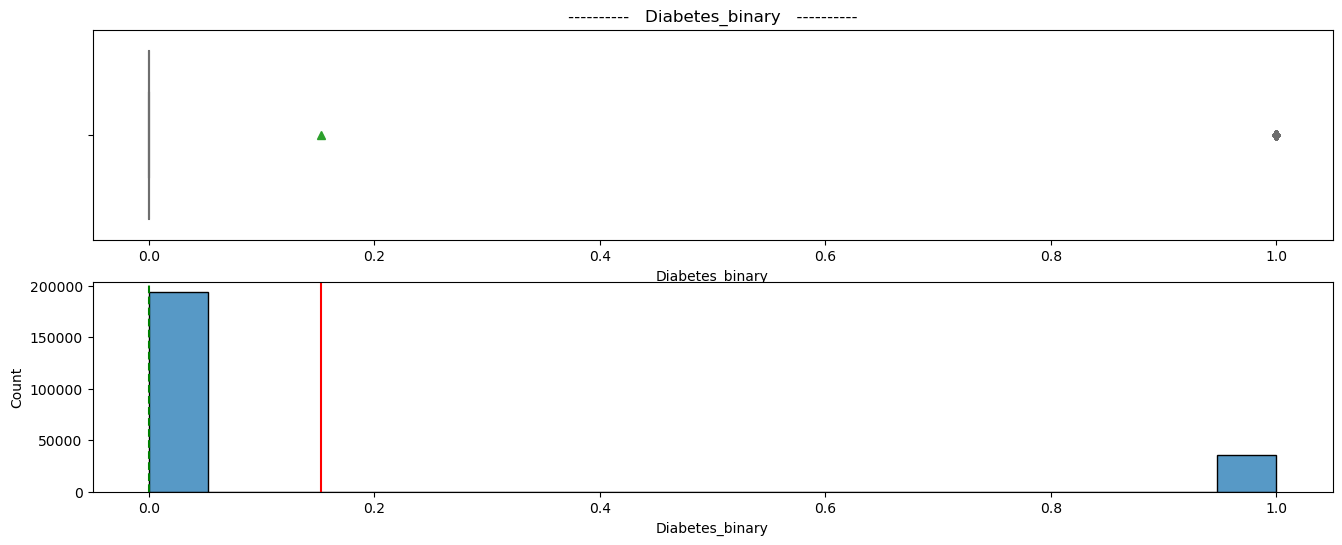

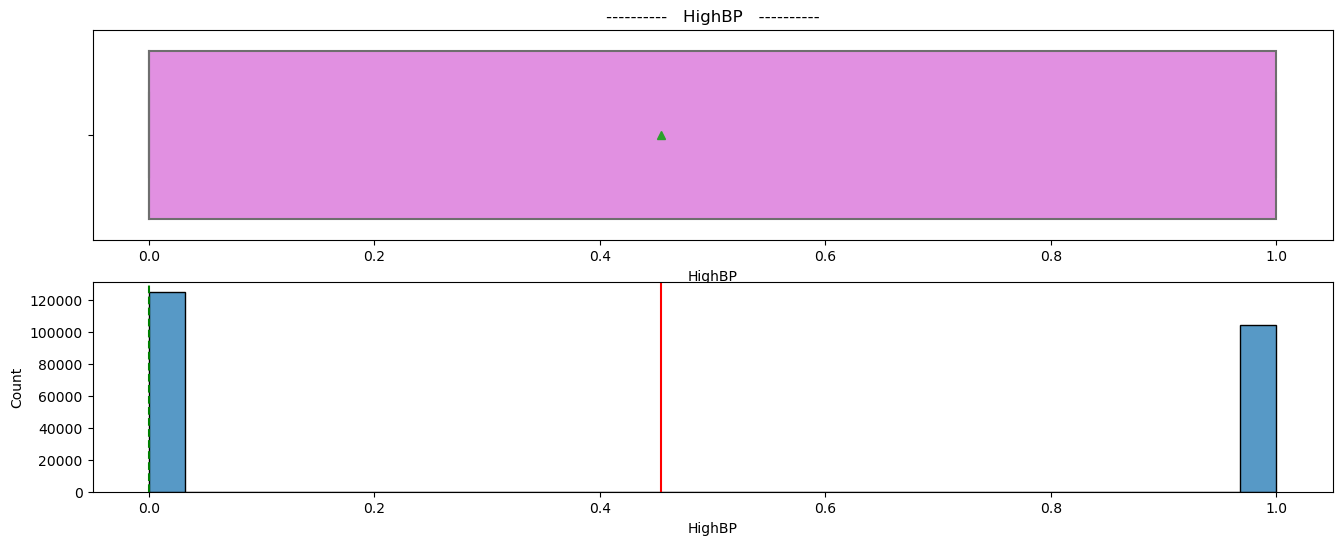

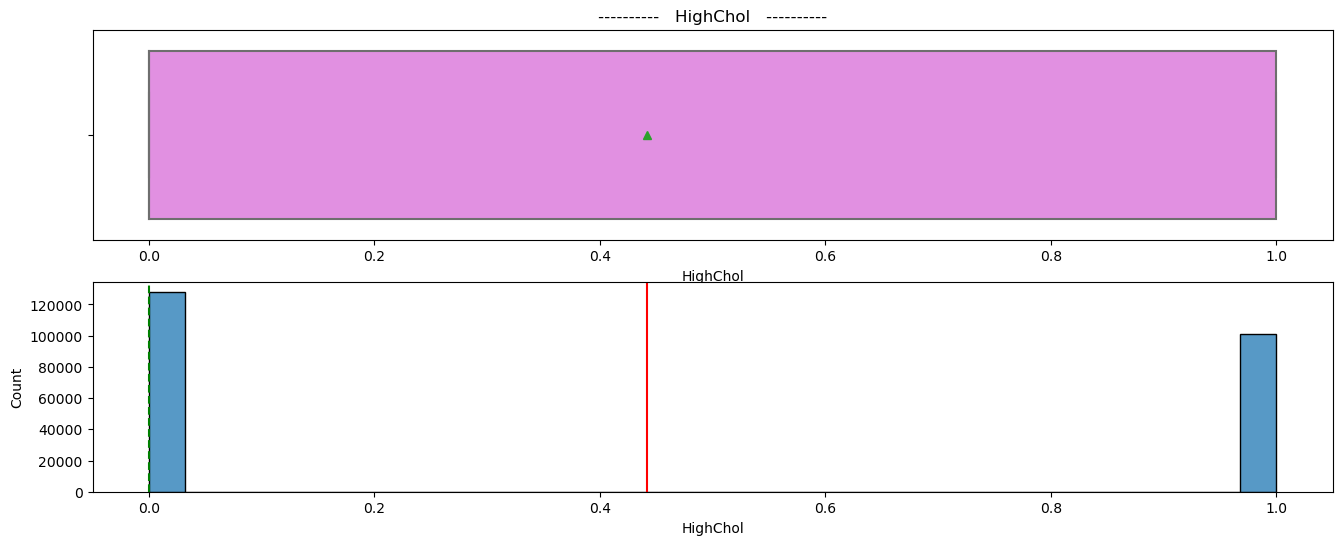

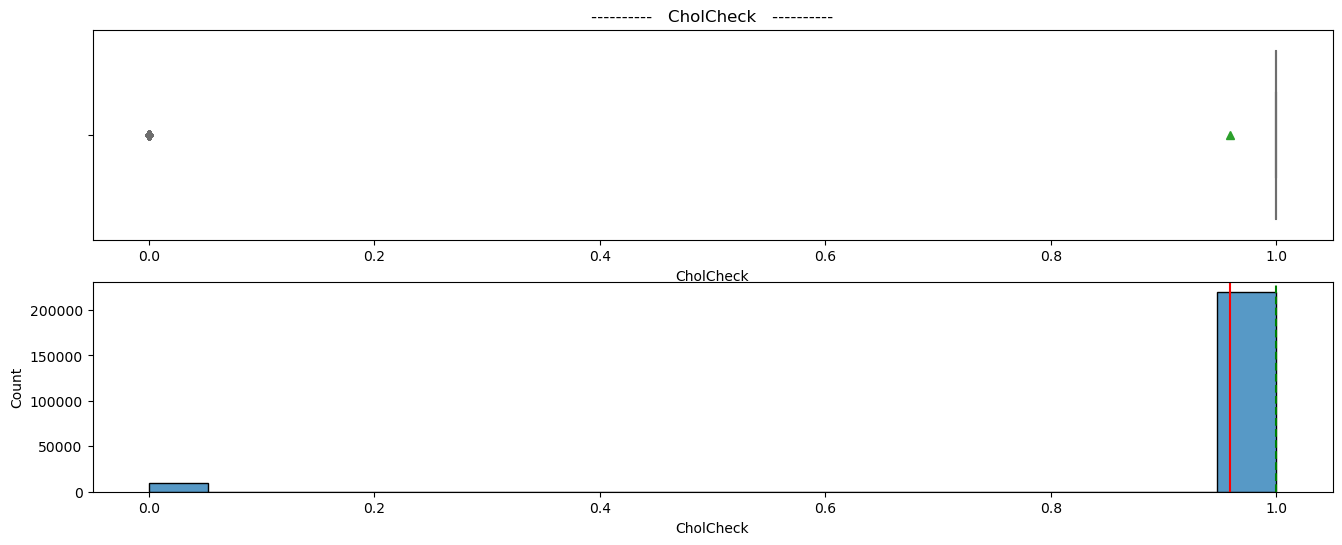

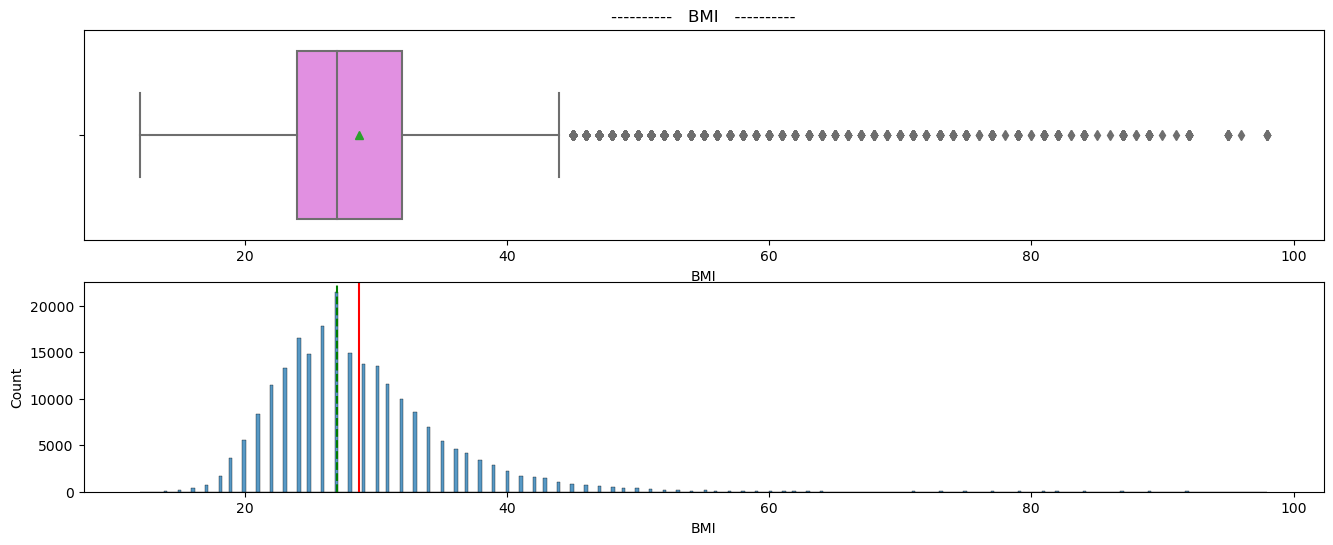

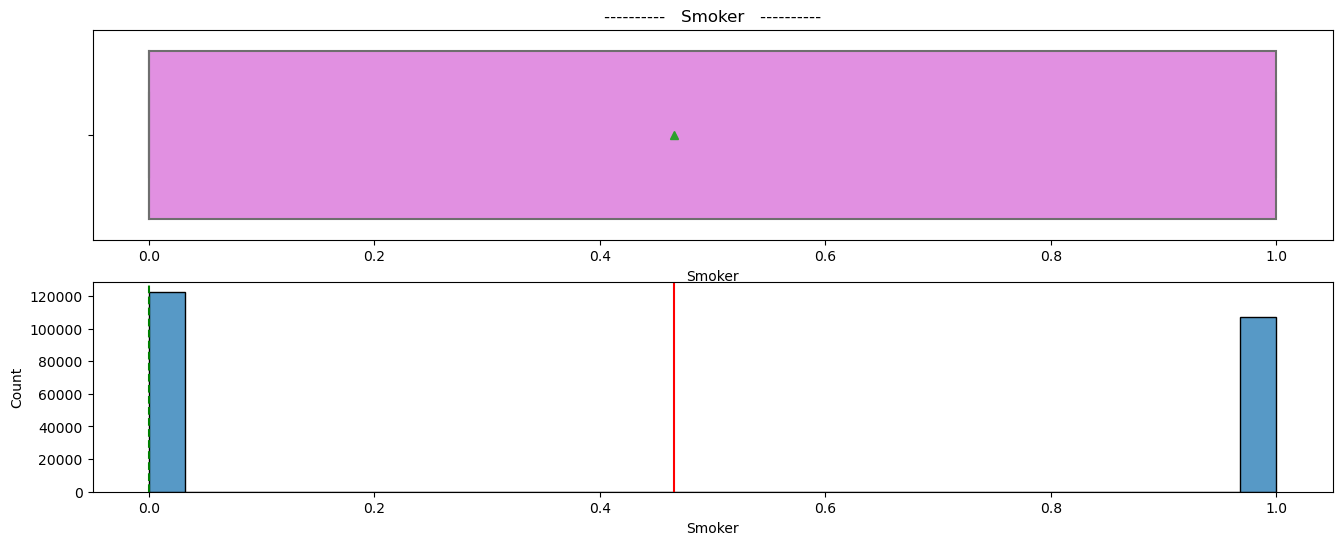

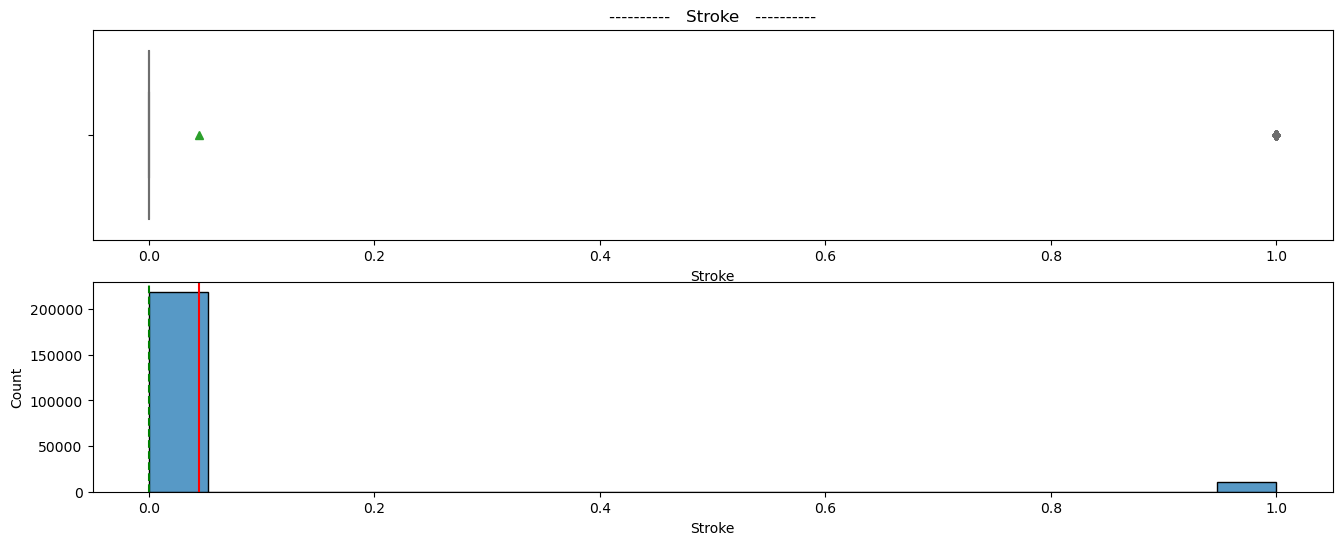

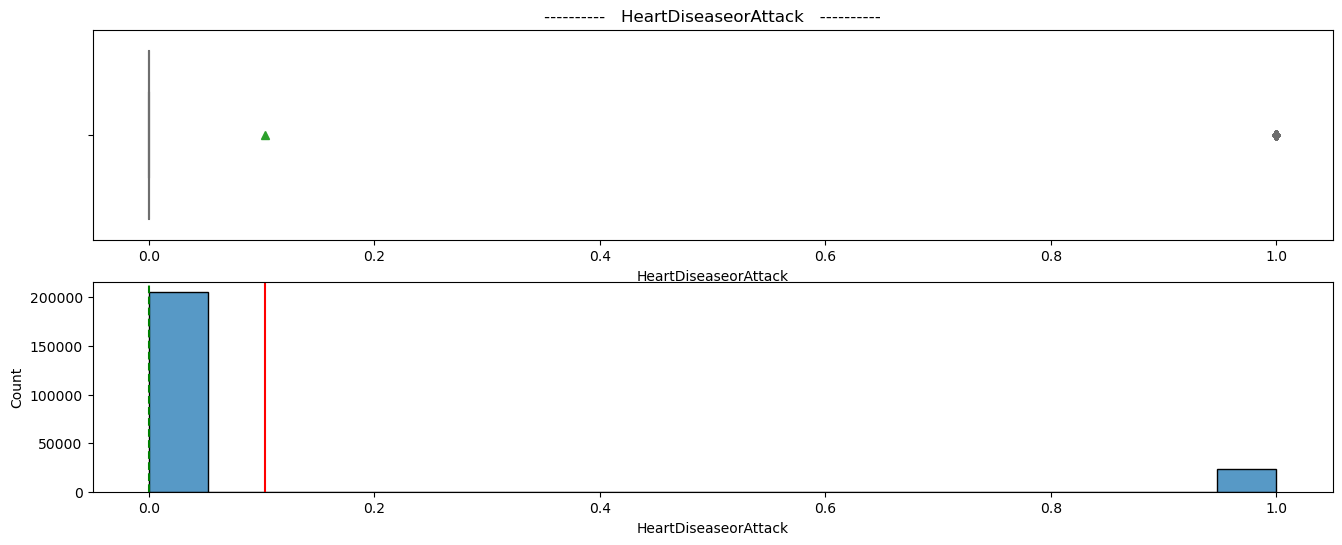

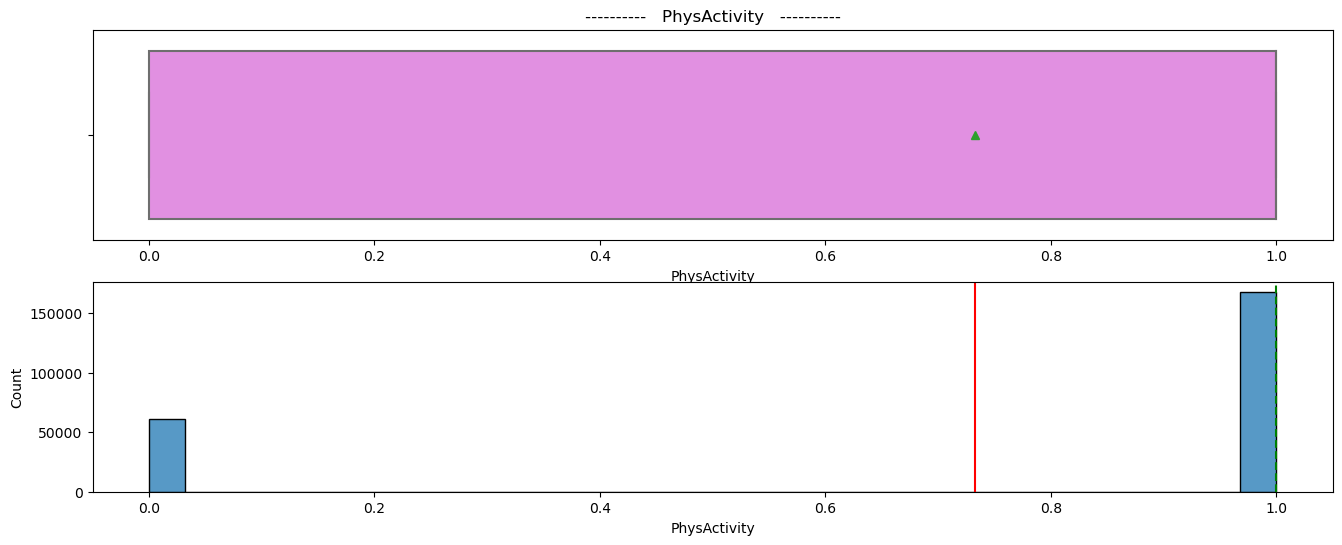

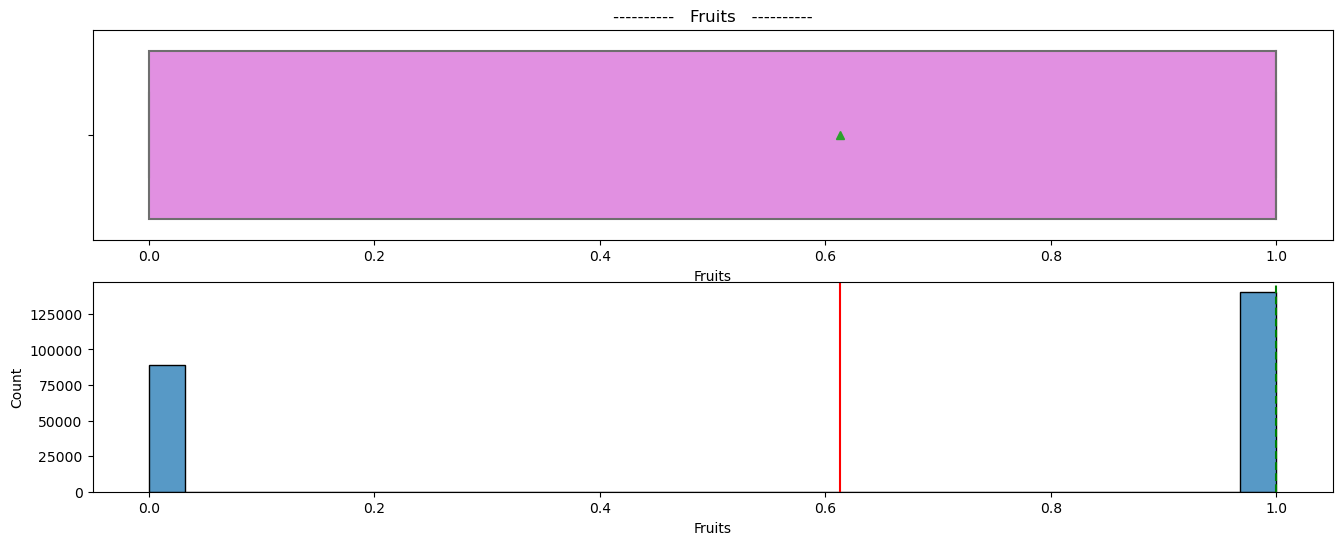

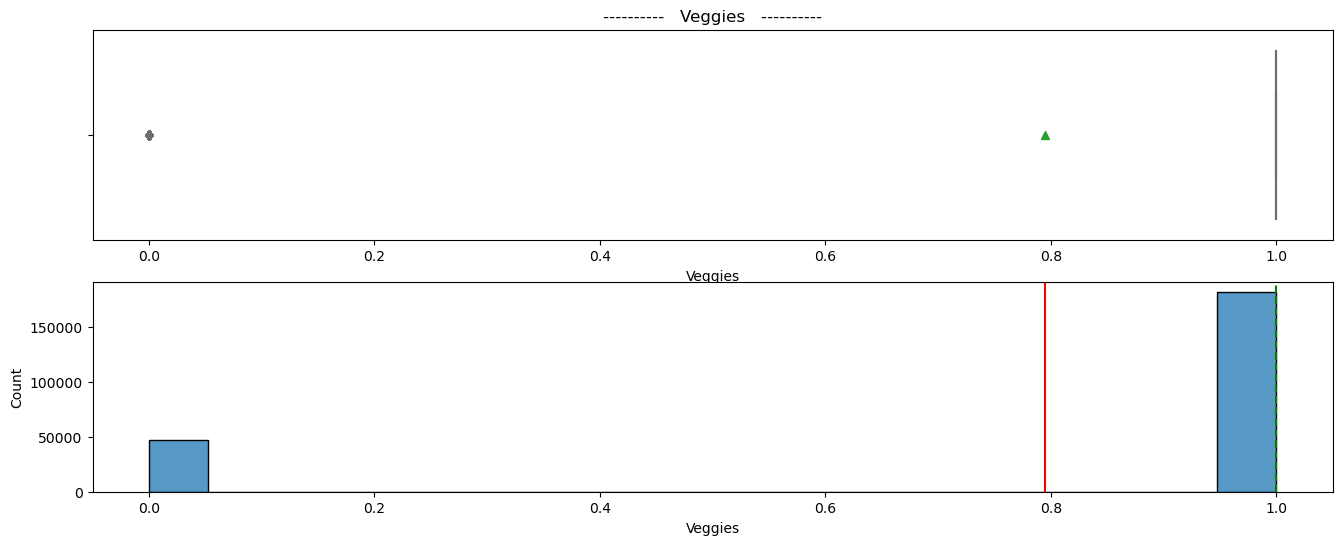

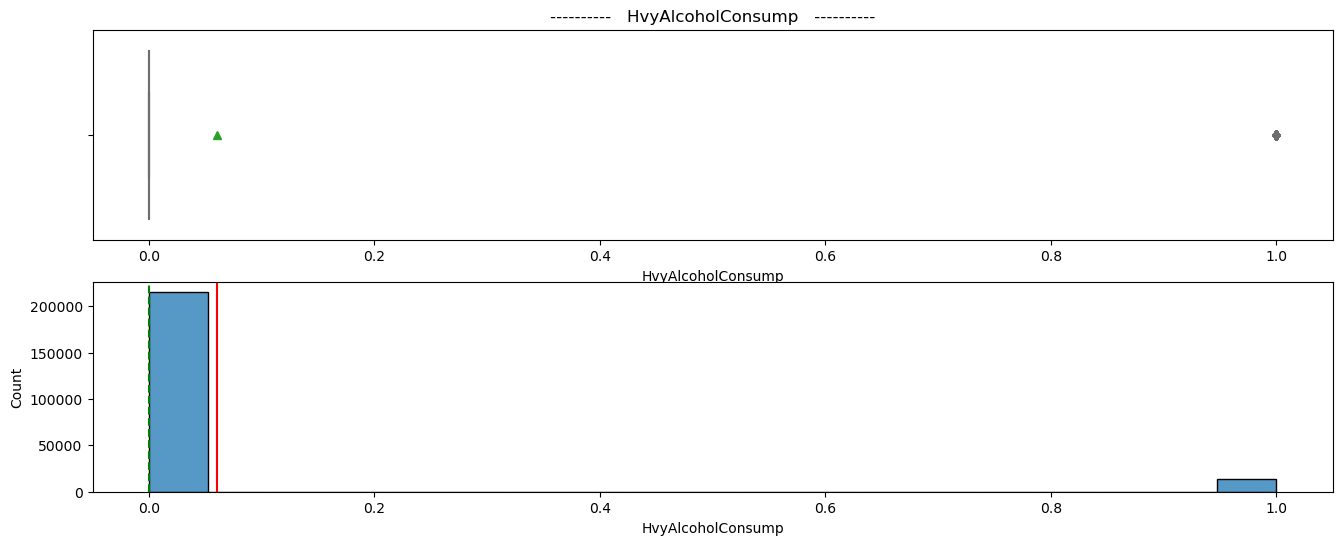

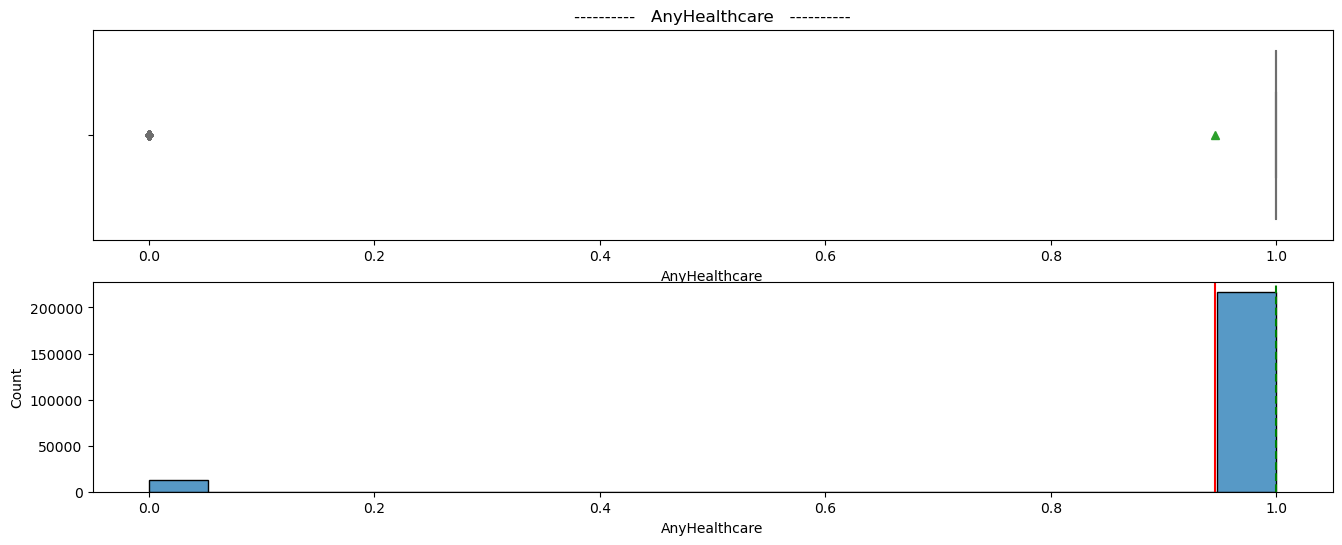

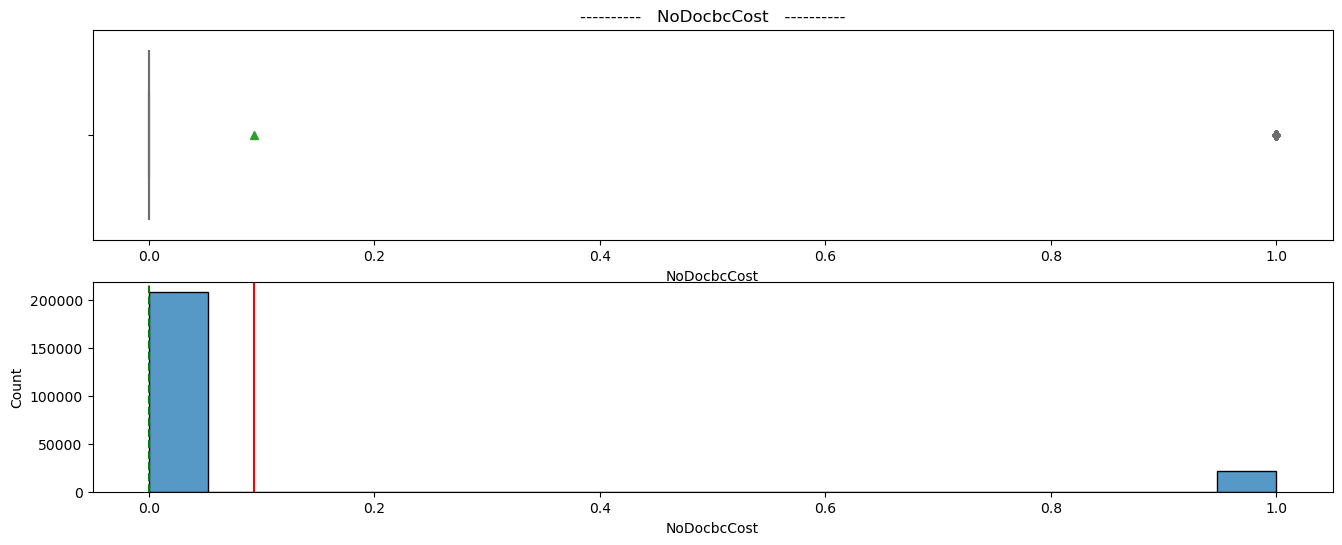

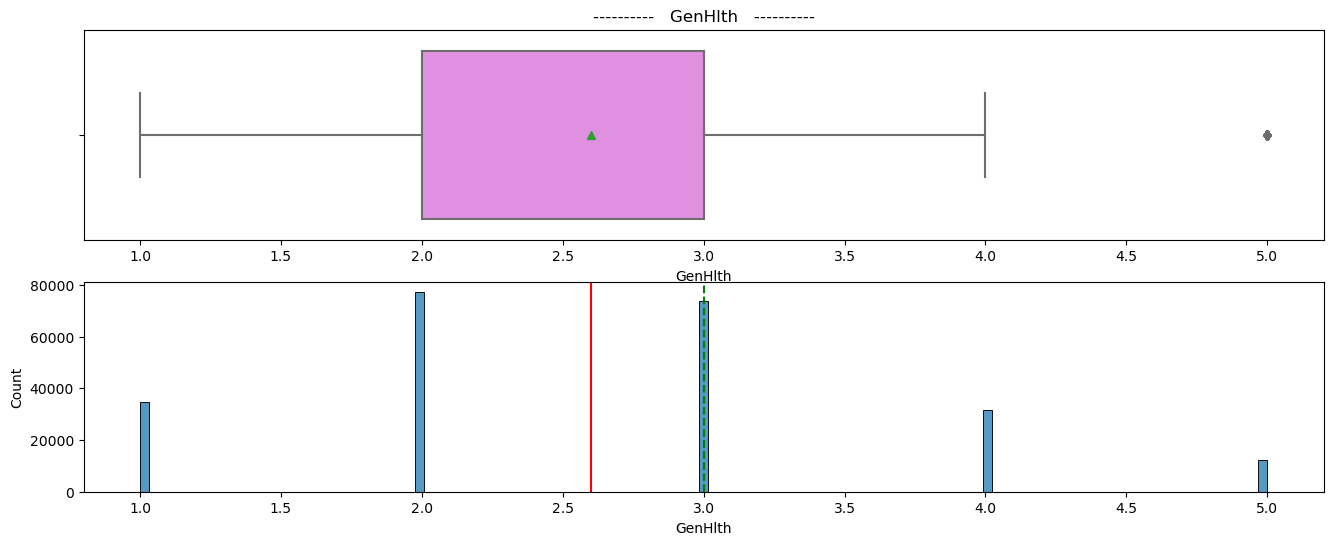

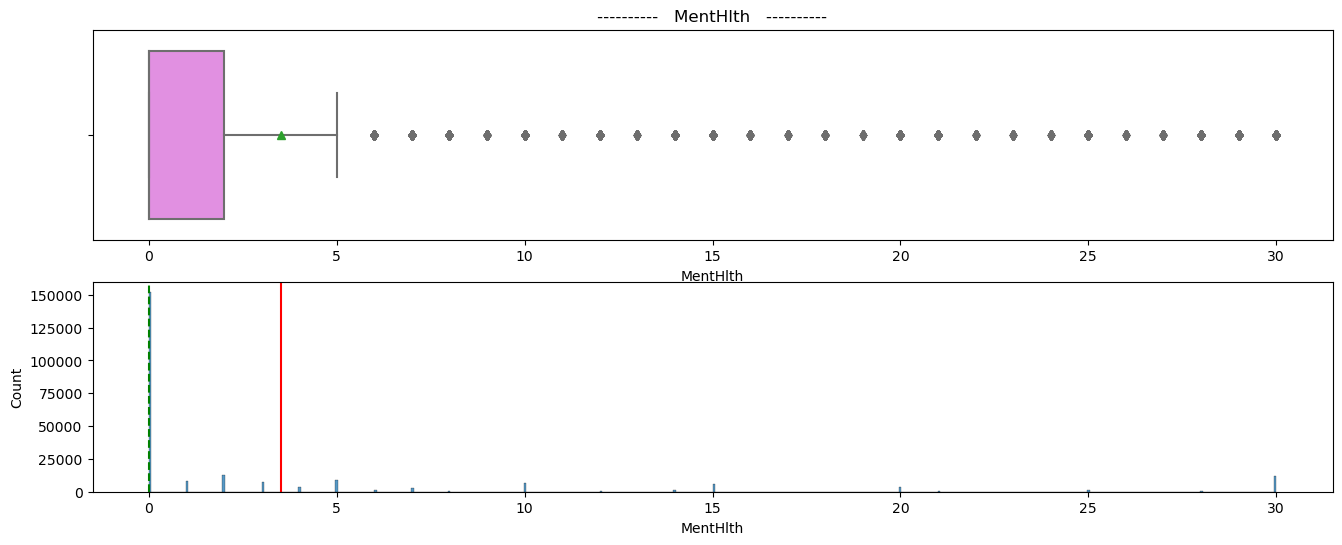

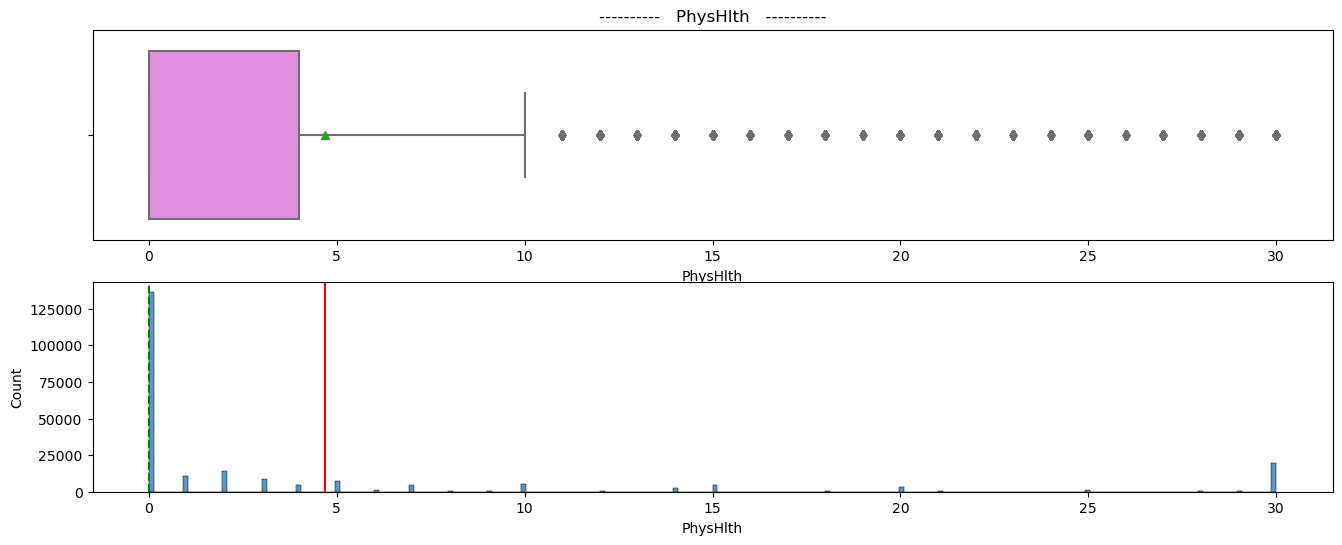

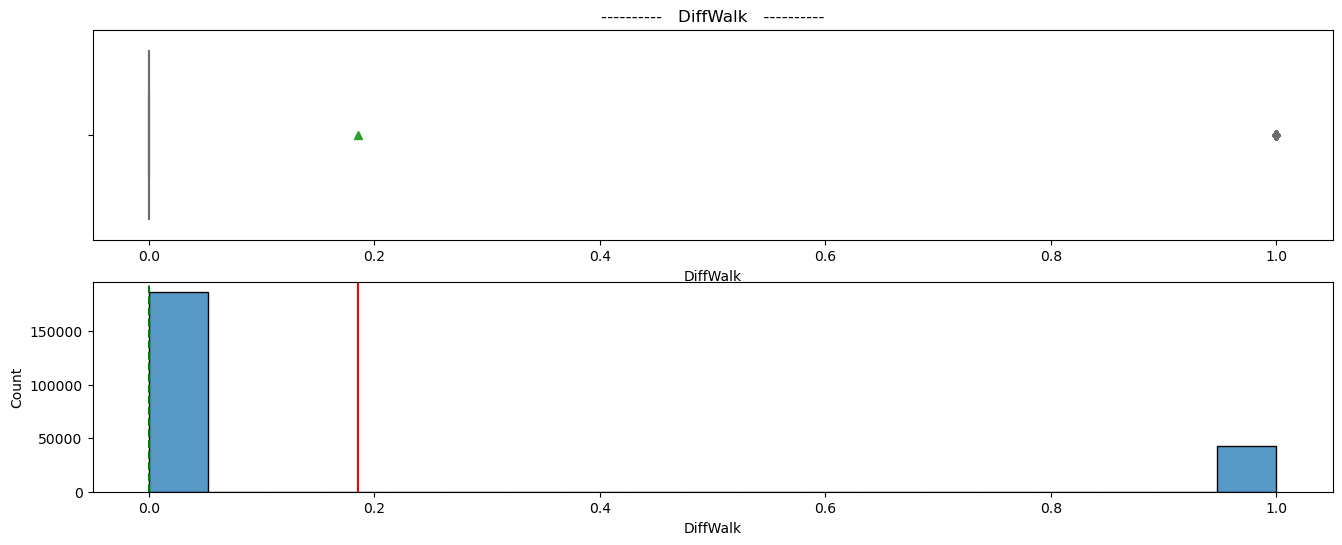

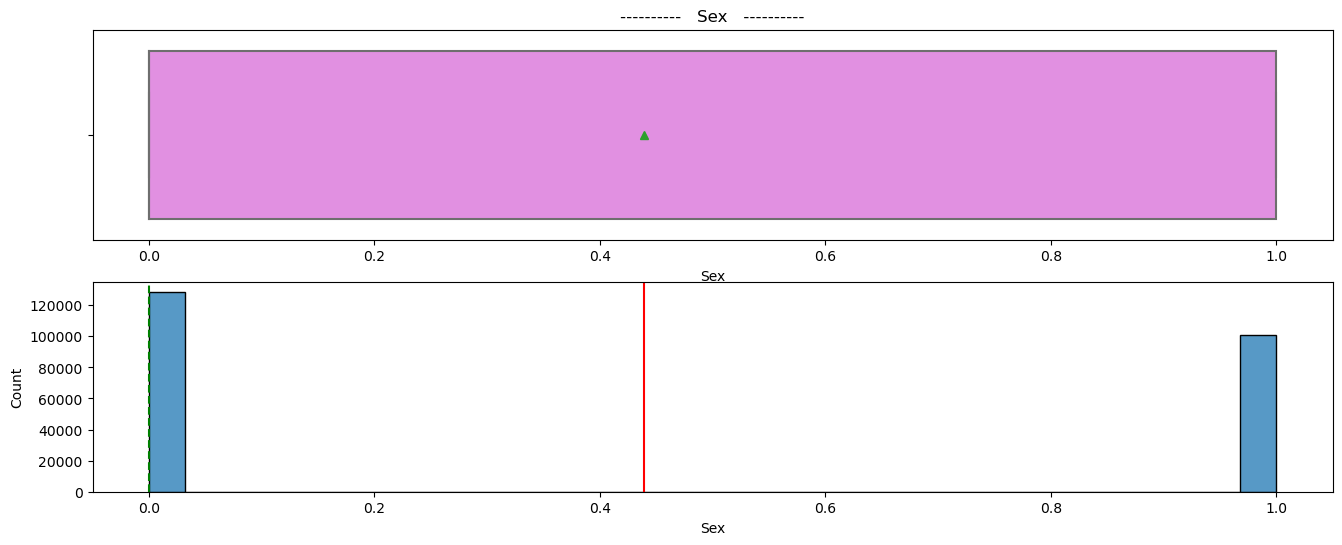

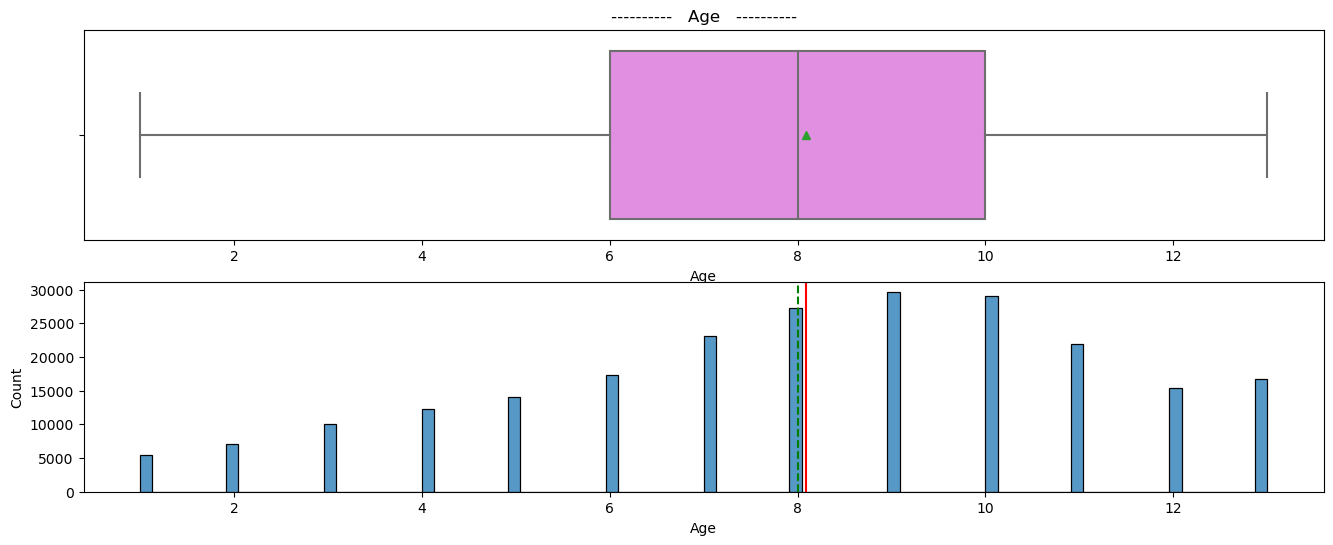

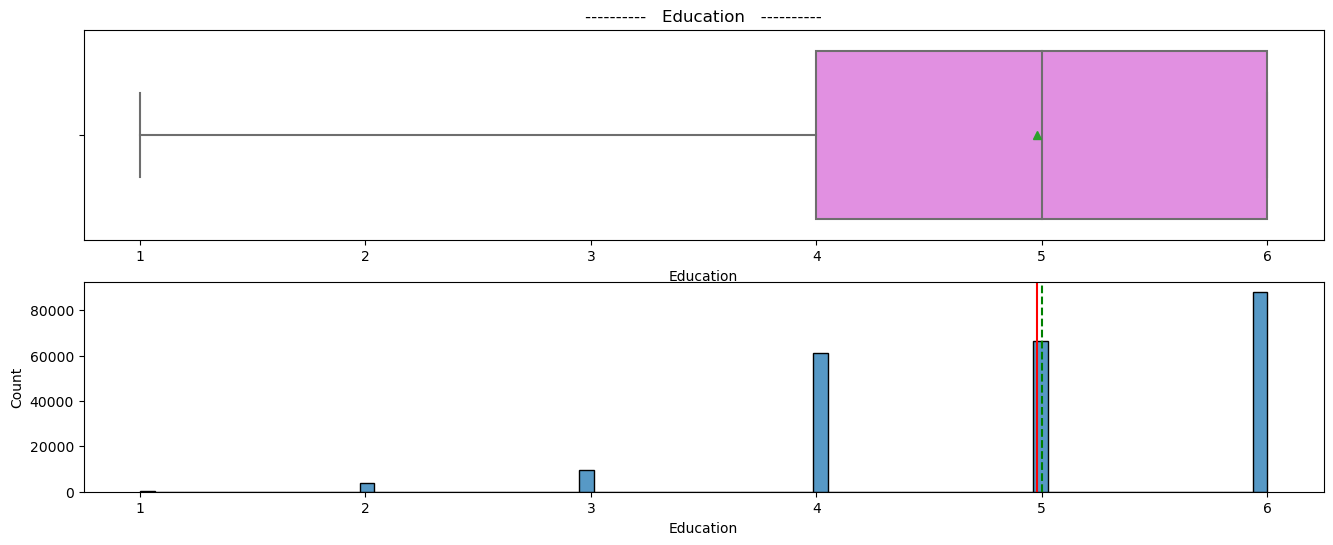

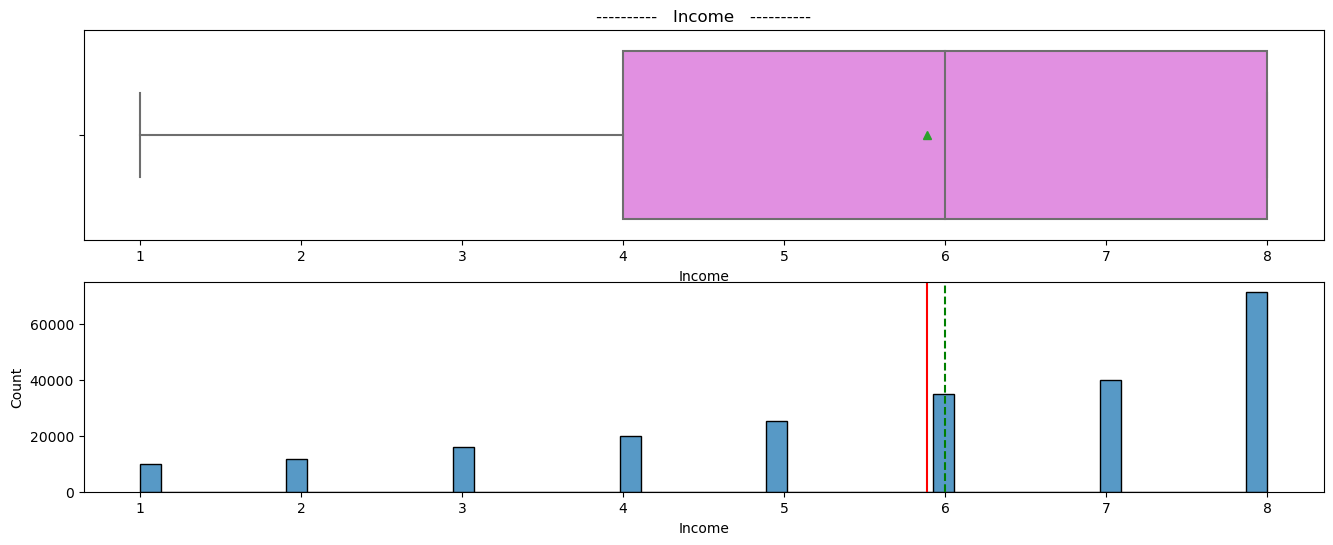

<IPython.core.display.Javascript object>

In [11]:
for col in data.columns:
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.title("----------   " + col + "   ----------")
    sns.boxplot(data=data, x=col, showmeans=True, color="violet")
    plt.subplot(2, 1, 2)
    sns.histplot(data=data, x=col)
    plt.axvline(data[col].mean(), color="red", linestyle="-")
    plt.axvline(data[col].median(), color="green", linestyle="--")
    print('\n')
    plt.show()

In [12]:
data.corr()["Diabetes_binary"]

Diabetes_binary         1.000000
HighBP                  0.254318
HighChol                0.194944
CholCheck               0.072523
BMI                     0.205086
Smoker                  0.045504
Stroke                  0.099193
HeartDiseaseorAttack    0.168213
PhysActivity           -0.100404
Fruits                 -0.024805
Veggies                -0.041734
HvyAlcoholConsump      -0.065950
AnyHealthcare           0.025331
NoDocbcCost             0.020048
GenHlth                 0.276940
MentHlth                0.054153
PhysHlth                0.156211
DiffWalk                0.205302
Sex                     0.032724
Age                     0.177263
Education              -0.102686
Income                 -0.140659
Name: Diabetes_binary, dtype: float64

<IPython.core.display.Javascript object>

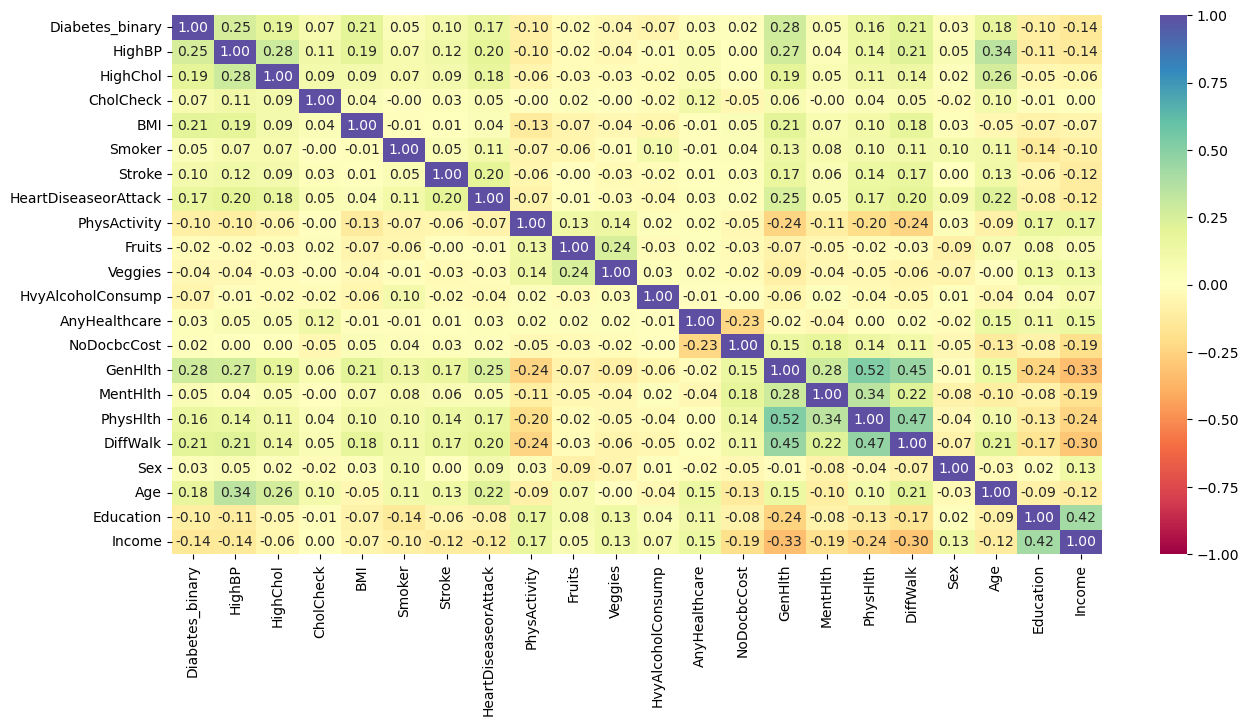

<IPython.core.display.Javascript object>

In [13]:
# correlation heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

In [14]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

In [15]:
columns = data.columns
columns = [col for col in columns if col != 'BMI' and col != 'Diabetes_binary']
columns

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

<IPython.core.display.Javascript object>

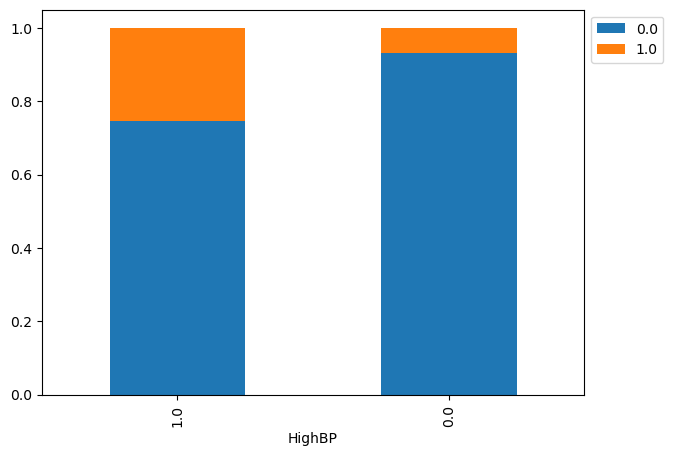

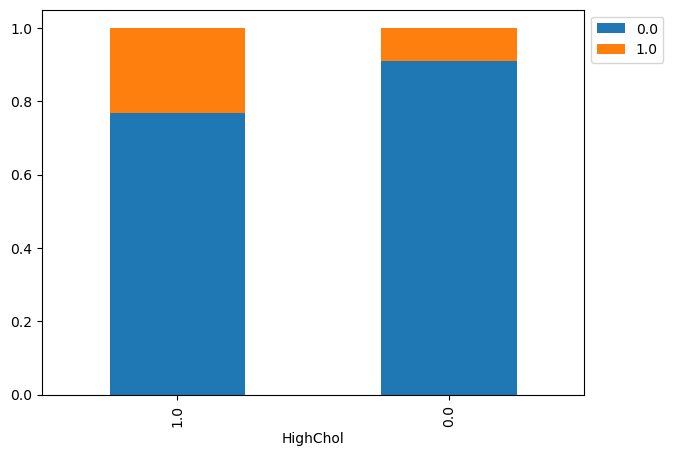

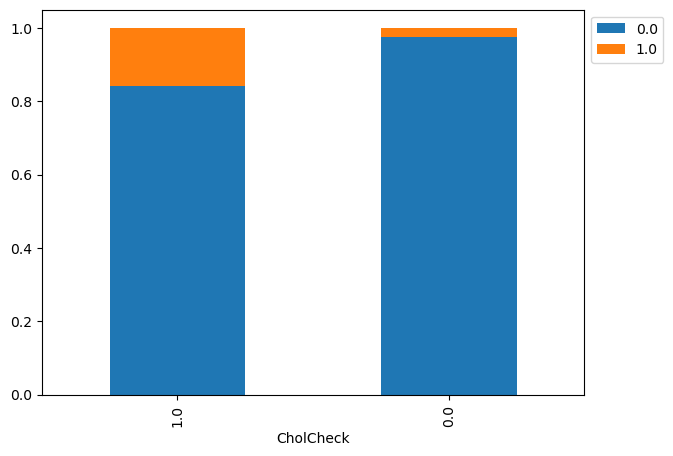

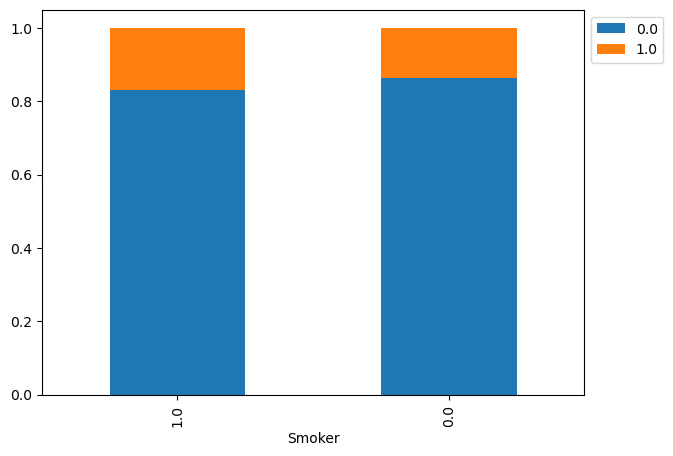

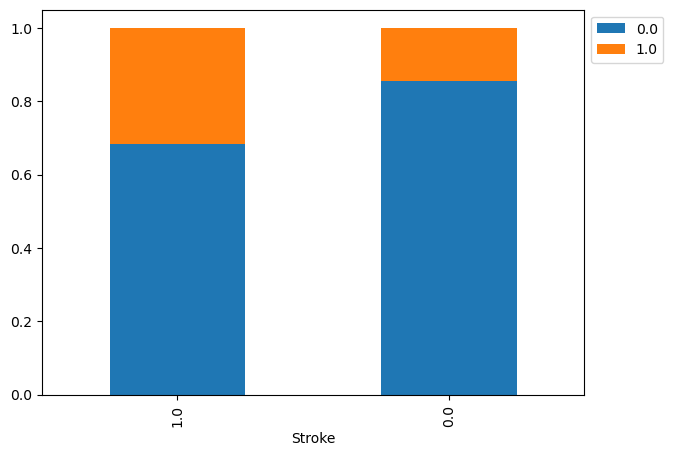

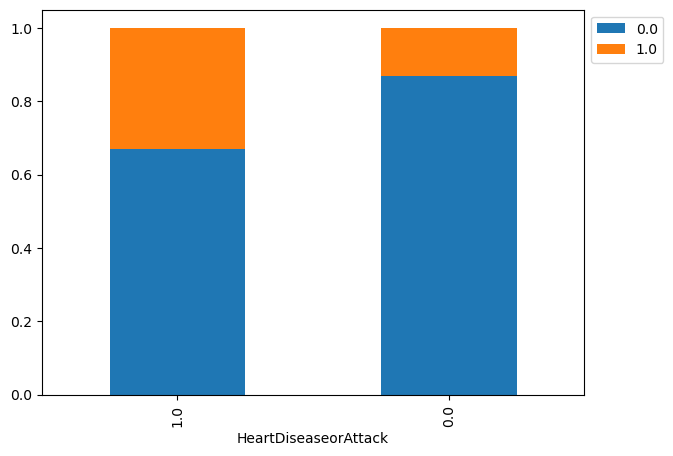

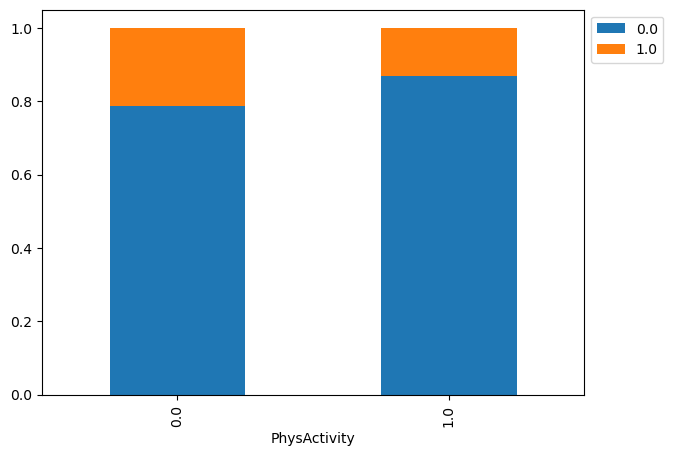

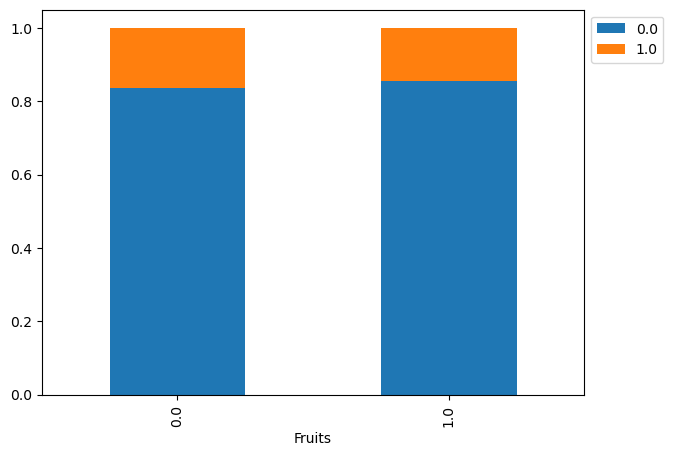

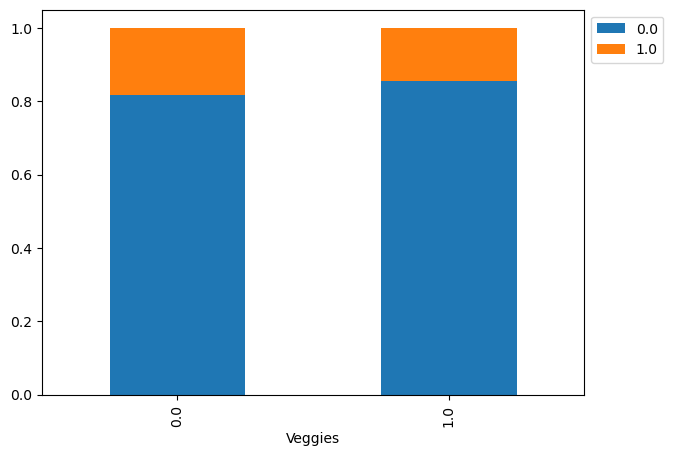

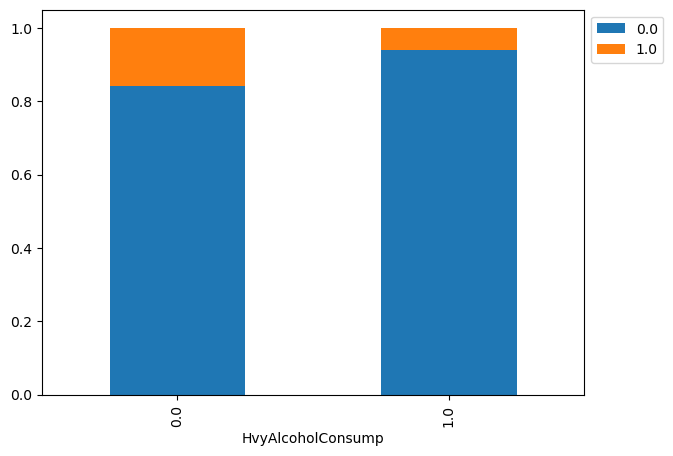

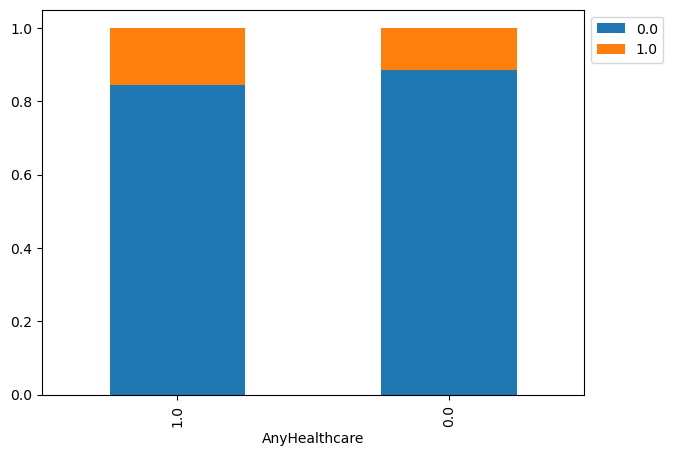

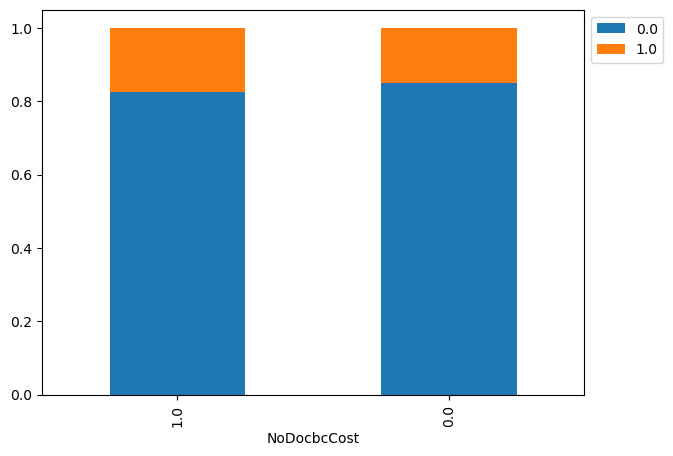

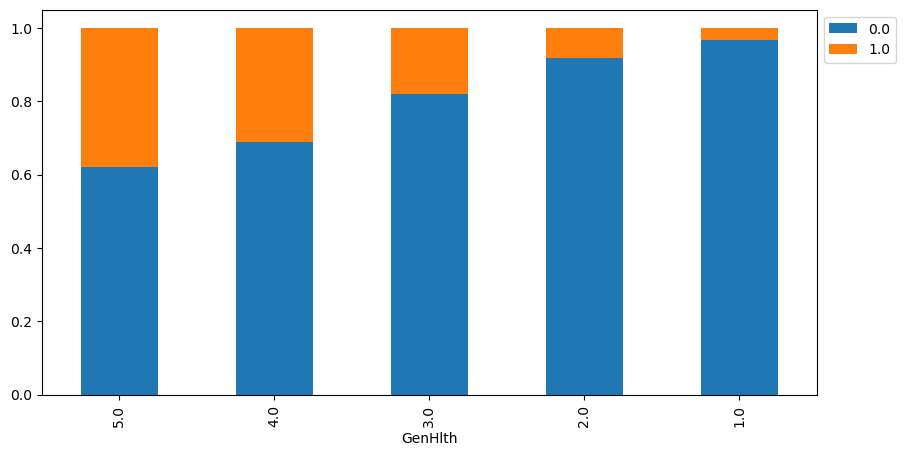

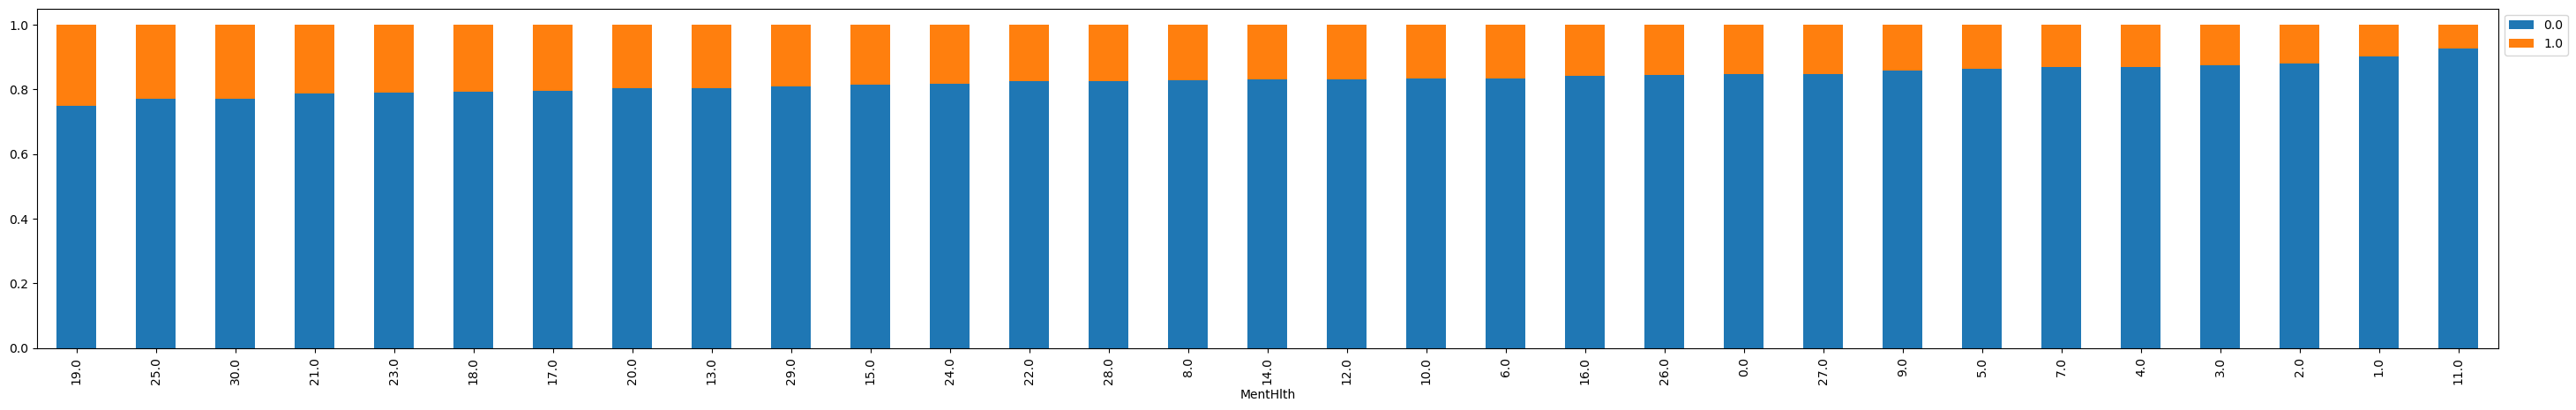

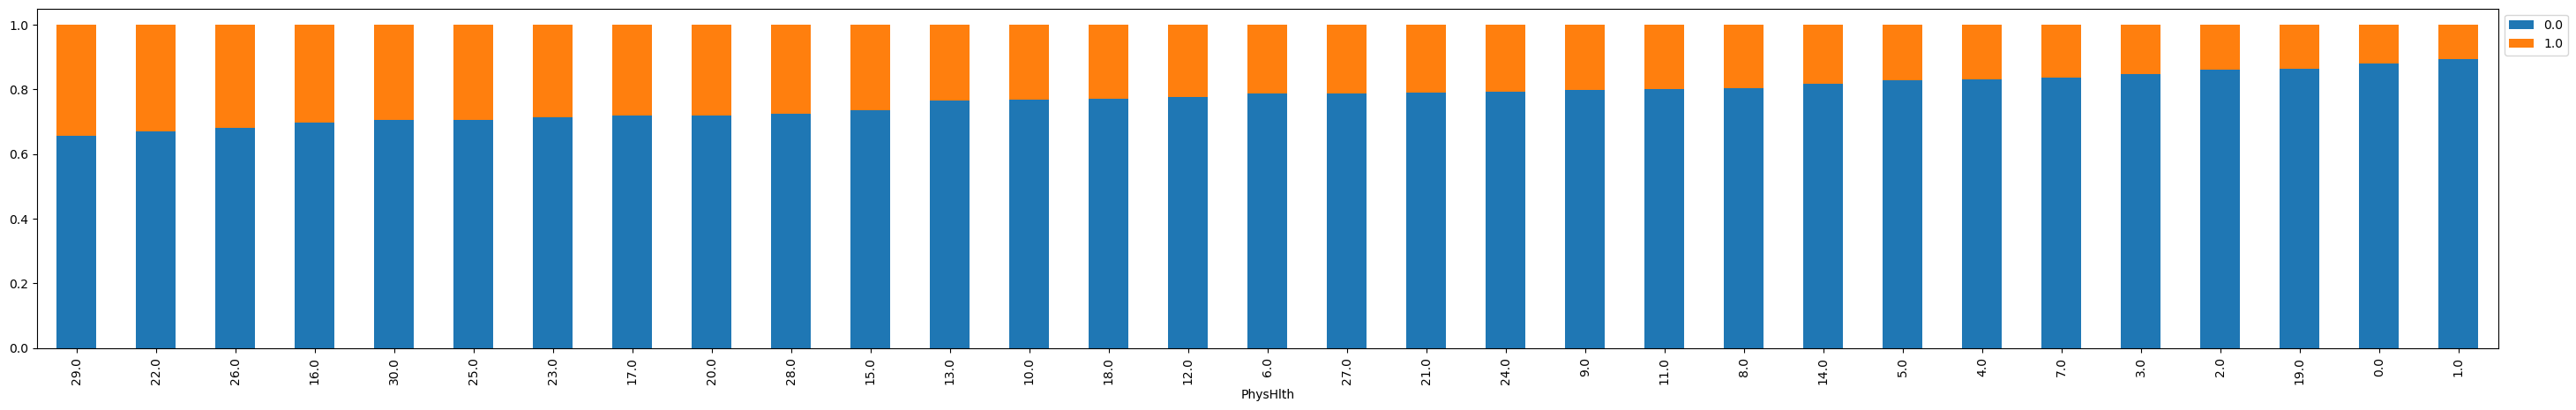

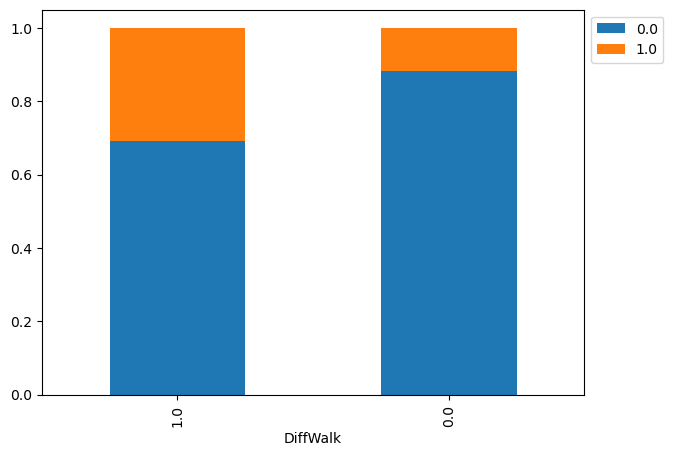

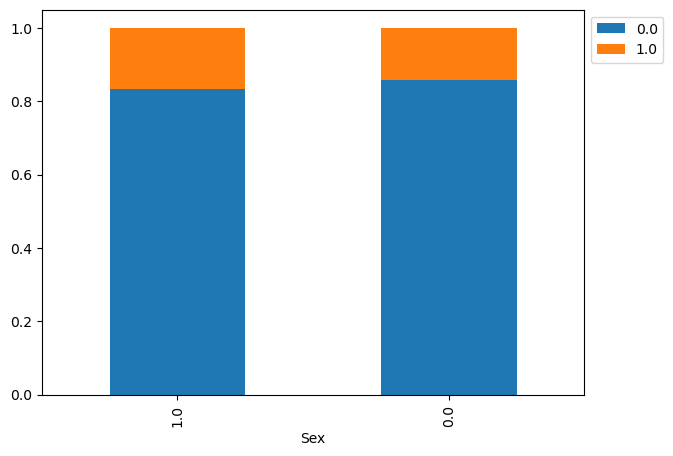

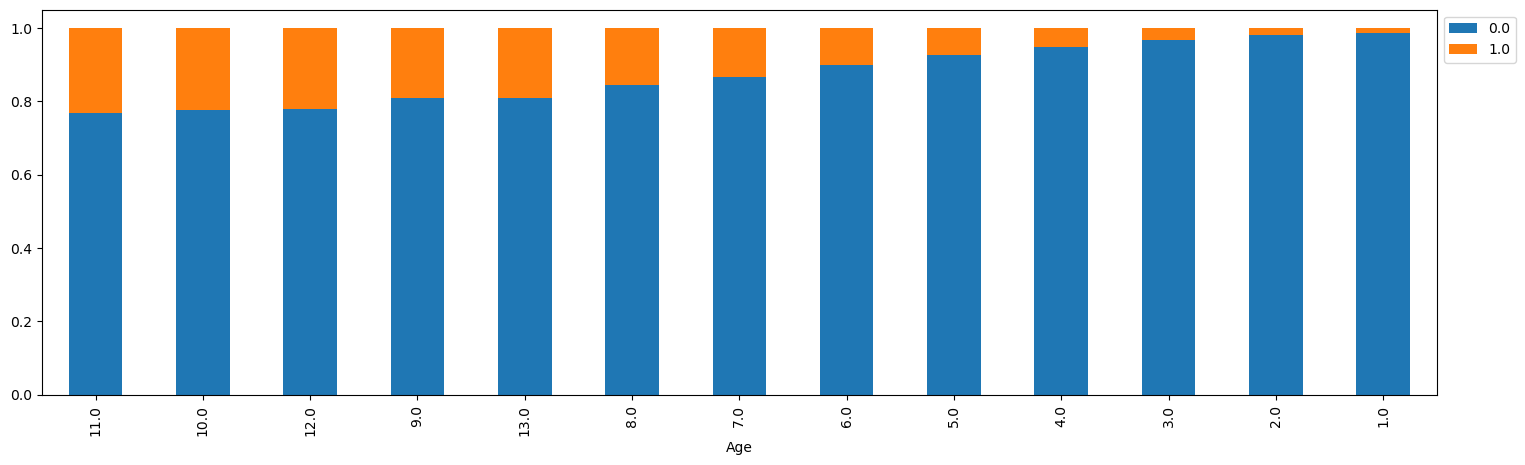

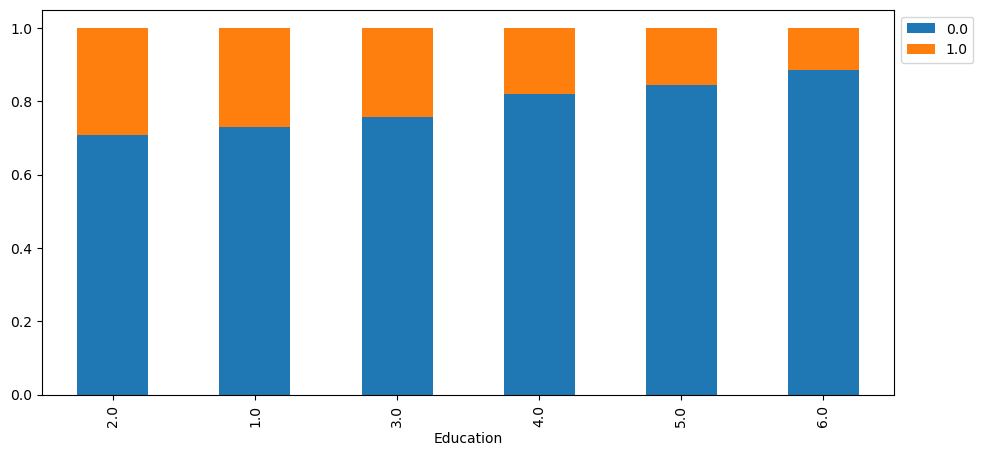

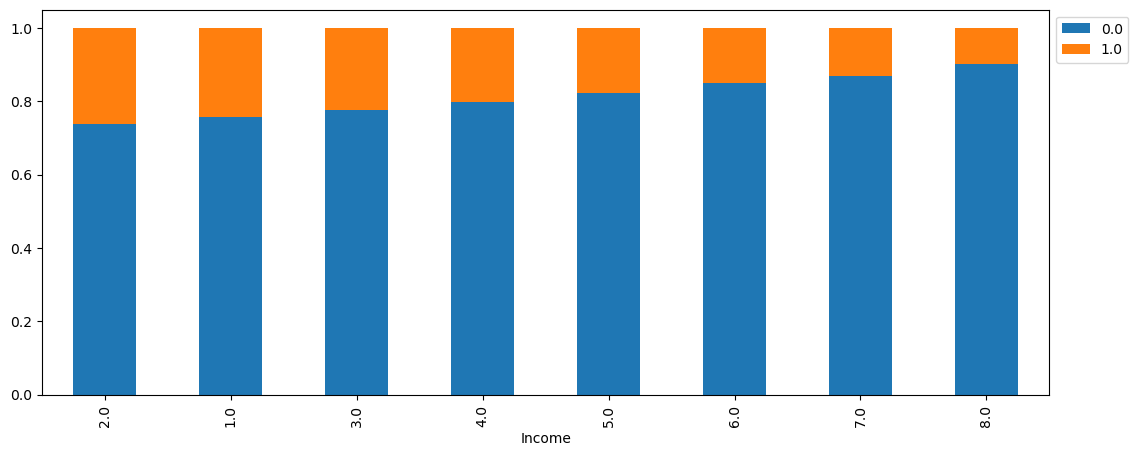

<IPython.core.display.Javascript object>

In [16]:
for col in columns:
    stacked_barplot(data, col, 'Diabetes_binary')

## Splitting the data

In [17]:
X,y = data.drop('Diabetes_binary', axis = 1), data['Diabetes_binary']

<IPython.core.display.Javascript object>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

<IPython.core.display.Javascript object>

In [19]:
print(f'Class dsitribution in the Original Data :')
print(y.value_counts())
print(f'Class dsitribution in the Training Data :')
print(y_train.value_counts())
print(f'Class dsitribution in the Testing Data :')
print(y_test.value_counts())

Class dsitribution in the Original Data :
0.0    194377
1.0     35097
Name: Diabetes_binary, dtype: int64
Class dsitribution in the Training Data :
0.0    155501
1.0     28078
Name: Diabetes_binary, dtype: int64
Class dsitribution in the Testing Data :
0.0    38876
1.0     7019
Name: Diabetes_binary, dtype: int64


<IPython.core.display.Javascript object>

In [20]:
print(f'Proportion of Positive Class in the Original Data : {35097/X.shape[0]}')
print(f'Proportion of Positive Class in the Training Data : {28078/X_train.shape[0]}')
print(f'Proportion of Positive Class in the Testing Data  : {7019/X_test.shape[0]}')

Proportion of Positive Class in the Original Data : 0.1529454317264701
Proportion of Positive Class in the Training Data : 0.15294777725121064
Proportion of Positive Class in the Testing Data  : 0.15293604967861424


<IPython.core.display.Javascript object>

## Scaling the data

In [21]:
scaler = StandardScaler()

<IPython.core.display.Javascript object>

In [22]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

<IPython.core.display.Javascript object>

## Model Building

### Logistic Regression

In [23]:
# Training the Logistic Regression model
logit = LogisticRegression(random_state = 42)
logit.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

<IPython.core.display.Javascript object>

In [24]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
logit_train_perf = model_performance_classification_sklearn(logit, X_train_scaled, y_train)
display(logit_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
logit_test_perf = model_performance_classification_sklearn(logit, X_test_scaled, y_test)
display(logit_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.850397,0.148515,0.539736,0.232935


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.85055,0.154153,0.53992,0.239832


<IPython.core.display.Javascript object>

In [25]:
# evaluation metrics for classification
print(classification_report(y_test, logit.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     38876
         1.0       0.54      0.15      0.24      7019

    accuracy                           0.85     45895
   macro avg       0.70      0.57      0.58     45895
weighted avg       0.82      0.85      0.81     45895



<IPython.core.display.Javascript object>

##### Confusion Matrix

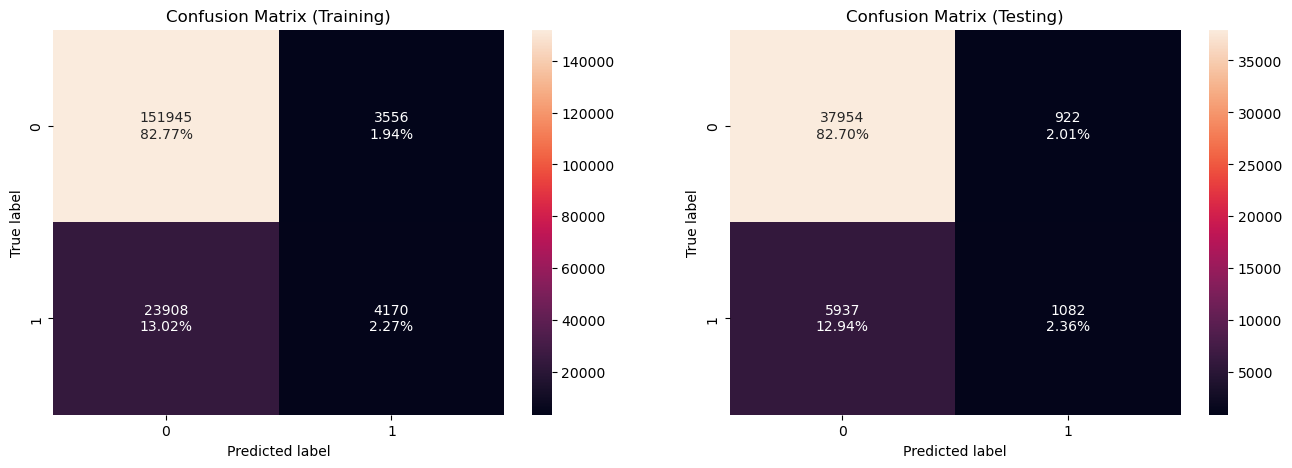

<IPython.core.display.Javascript object>

In [26]:
# creating confusion matrix for the training dataset
# model performance on the training dataset
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
# plot 1
cm, labels = confusion_matrix_helper(logit, X_train_scaled, y_train, threshold=0.5)
sns.heatmap(cm, annot=labels, fmt="", ax=ax1)
#ConfusionMatrixDisplay(confusion_matrix(y_train, logit.predict(X_train))).plot(ax=ax1)
ax1.set_title('Confusion Matrix (Training)')
ax1.set_ylabel("True label")
ax1.set_xlabel("Predicted label")
# plot 2
#ConfusionMatrixDisplay(confusion_matrix(y_test, logit.predict(X_test))).plot(ax=ax2)
cm, labels = confusion_matrix_helper(logit, X_test_scaled, y_test, threshold=0.5)
sns.heatmap(cm, annot=labels, fmt="", ax=ax2)
ax2.set_title('Confusion Matrix (Testing)')
ax2.set_ylabel("True label")
ax2.set_xlabel("Predicted label")
plt.show()

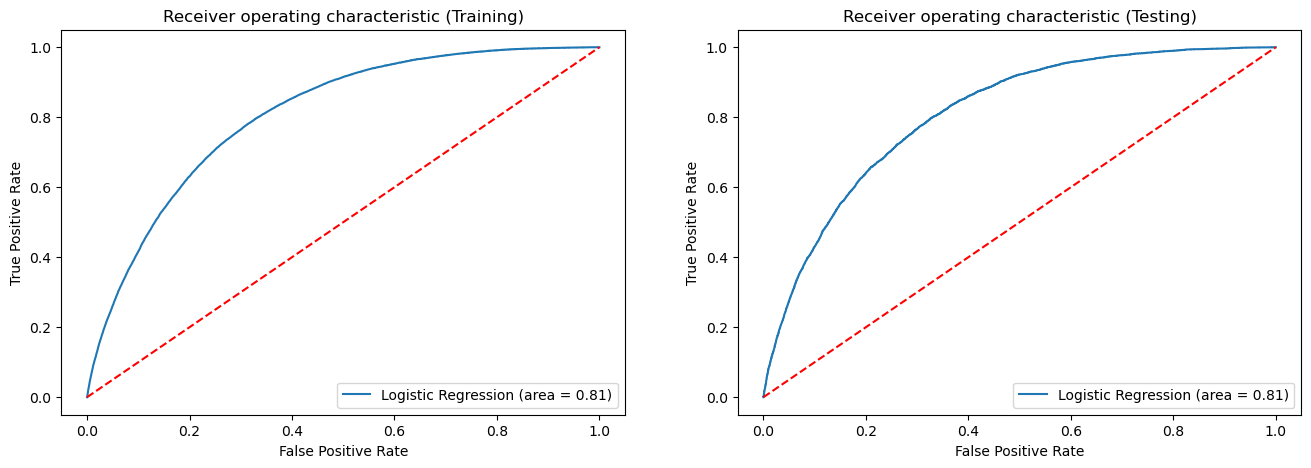

<IPython.core.display.Javascript object>

In [27]:
# ROC curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
logit_roc_auc_train = roc_auc_score(y_train, logit.predict_proba(X_train_scaled)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, logit.predict_proba(X_train_scaled)[:,1])
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Training)")
plt.legend(loc="lower right")
#plt.show()
plt.subplot(1, 2, 2)
logit_roc_auc_test = roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1])
fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test, logit.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr_tst, tpr_tst, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Testing)")
plt.legend(loc="lower right")
plt.show()

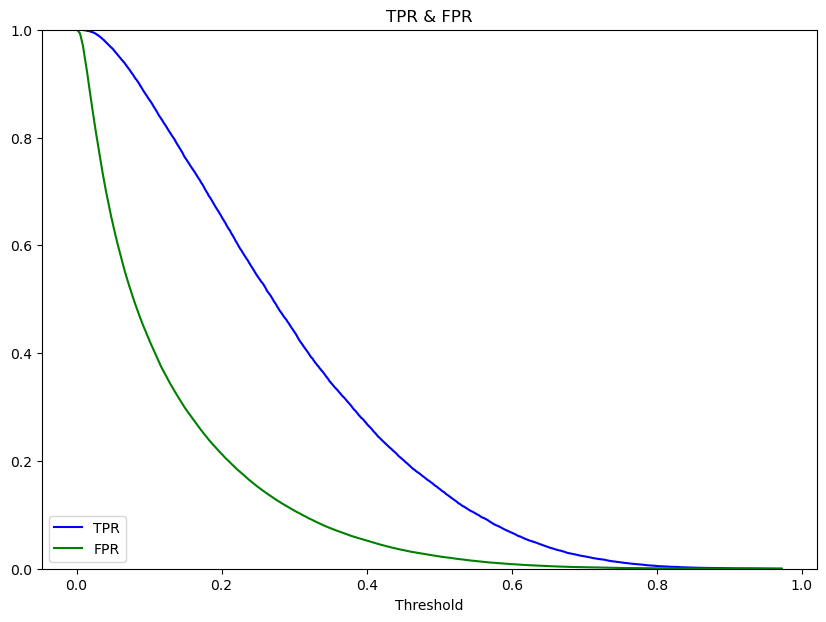

<IPython.core.display.Javascript object>

In [28]:
# tpr and fpr curve as a function of threshold
plt.figure(figsize=(10, 7))
plt.plot(thresholds, tpr, "b", label="TPR")
plt.plot(thresholds, fpr, "g", label="FPR")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.title("TPR & FPR")
plt.ylim([0, 1])
plt.show()

In [29]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low (using the tpr and fpr from the training dataset)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print('Optimal classification threshold based on ROC Curve: {}'.format(optimal_threshold_auc_roc))

Optimal classification threshold based on ROC Curve: 0.14250916077954337


<IPython.core.display.Javascript object>

In [30]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
logit_thres_train_perf = model_performance_classification_sklearn(logit, X_train_scaled, y_train, optimal_threshold_auc_roc)
display(logit_thres_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
logit_thres_test_perf = model_performance_classification_sklearn(logit, X_test_scaled, y_test, optimal_threshold_auc_roc)
display(logit_thres_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.701344,0.779863,0.310406,0.444064


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.698137,0.785155,0.308618,0.443078


<IPython.core.display.Javascript object>

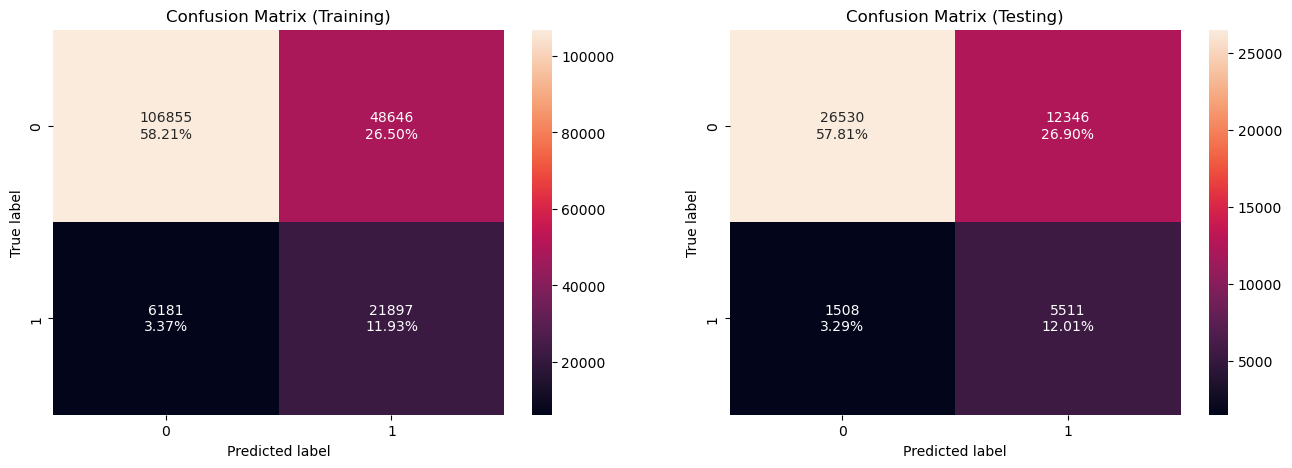

<IPython.core.display.Javascript object>

In [31]:
# confusion matrix at the optimal threshold based on ROC Curve
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
# plot 1
cm, labels = confusion_matrix_helper(logit, X_train_scaled, y_train, threshold=optimal_threshold_auc_roc)
sns.heatmap(cm, annot=labels, fmt="", ax=ax1)
ax1.set_title('Confusion Matrix (Training)')
ax1.set_ylabel("True label")
ax1.set_xlabel("Predicted label")
# plot 2
cm, labels = confusion_matrix_helper(logit, X_test_scaled, y_test, threshold=optimal_threshold_auc_roc)
sns.heatmap(cm, annot=labels, fmt="", ax=ax2)
ax2.set_title('Confusion Matrix (Testing)')
ax2.set_ylabel("True label")
ax2.set_xlabel("Predicted label")
plt.show()

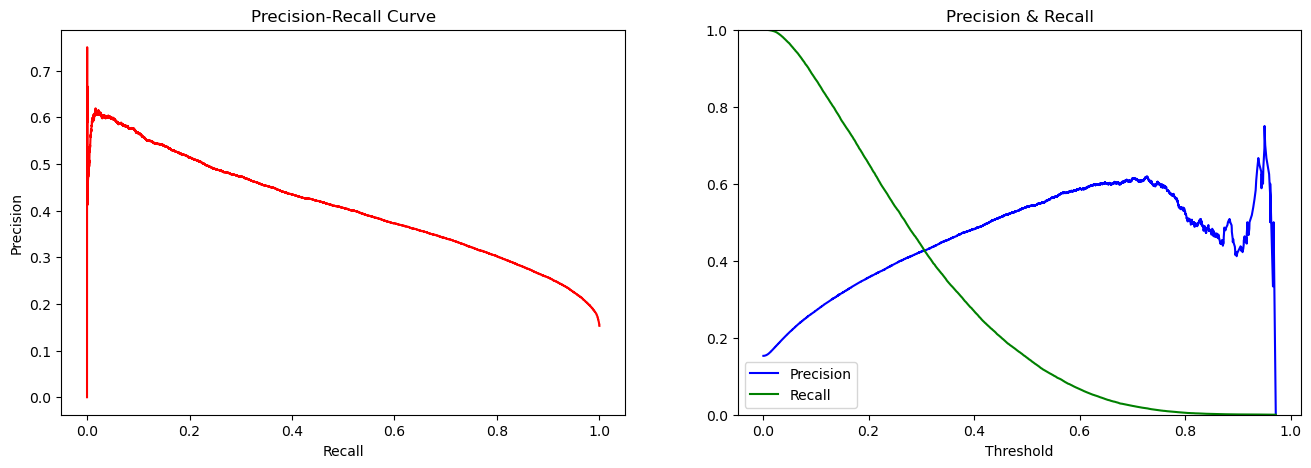

<IPython.core.display.Javascript object>

In [32]:
y_scores = logit.predict_proba(X_train_scaled)[:,1]
prec, rec, thres = precision_recall_curve(y_train, y_scores)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
# precision-recall curve
plt.plot(rec[:-1], prec[:-1], "r")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.subplot(1, 2, 2)
# precision and recall curve as a function of threshold
plt.plot(thres, prec[:-1], "b", thres, rec[:-1], "g")
plt.legend(['Precision','Recall'],loc="lower left")
plt.xlabel("Threshold")
plt.title("Precision & Recall")
plt.ylim([0, 1])

plt.show()


In [33]:
# optimal threshold (threshold where the precision and recall curves intersect)
optimal_idx = np.argmin(np.abs(prec - rec))
optimal_threshold_prec_rec = thres[optimal_idx]
print('Optimal classification threshold based on Precision-Recall Curve: {}'.format(optimal_threshold_prec_rec))


Optimal classification threshold based on Precision-Recall Curve: 0.3060461005261531


<IPython.core.display.Javascript object>

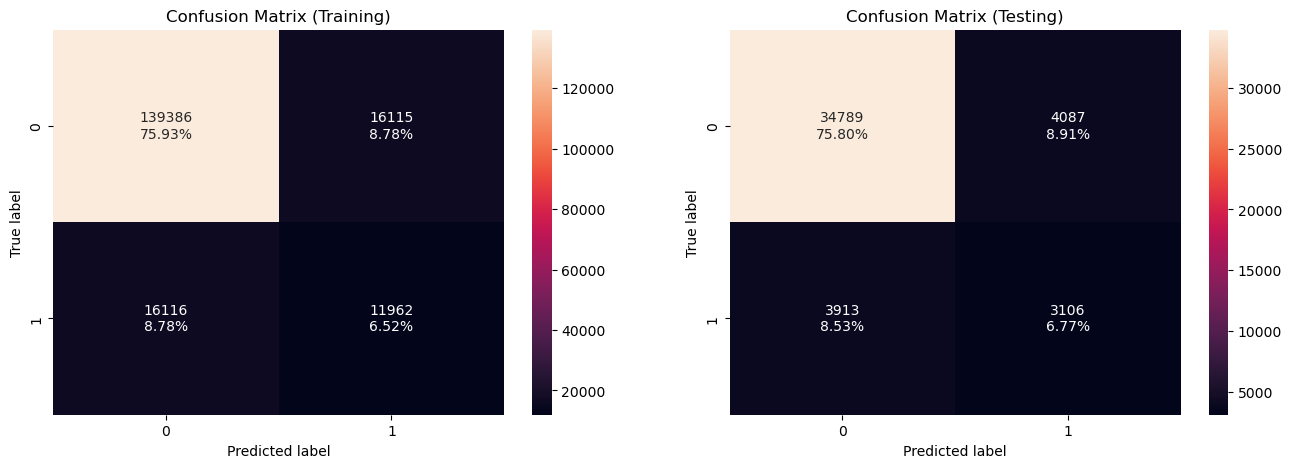

<IPython.core.display.Javascript object>

In [34]:
# confusion matrix at the optimal threshold
# confusion matrix at the optimal threshold based on ROC Curve
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
# plot 1
cm, labels = confusion_matrix_helper(logit, X_train_scaled, y_train, threshold=optimal_threshold_prec_rec)
sns.heatmap(cm, annot=labels, fmt="", ax=ax1)
ax1.set_title('Confusion Matrix (Training)')
ax1.set_ylabel("True label")
ax1.set_xlabel("Predicted label")
# plot 2
cm, labels = confusion_matrix_helper(logit, X_test_scaled, y_test, threshold=optimal_threshold_prec_rec)
sns.heatmap(cm, annot=labels, fmt="", ax=ax2)
ax2.set_title('Confusion Matrix (Testing)')
ax2.set_ylabel("True label")
ax2.set_xlabel("Predicted label")
plt.show()


In [35]:
# putting the model coefficients, their odds ratios and percent_change_odds in a single dataframe
features_names = ["Intercept"] + list(logit.feature_names_in_)
coef = list(logit.intercept_) + list(*logit.coef_)
logit_summary = pd.DataFrame({"Feature_Names": features_names, "Coefficient": coef})
logit_summary["odds"] = np.exp(logit_summary["Coefficient"])
logit_summary["percent_change_odds"] = (np.exp(logit_summary["Coefficient"]) - 1) * 100
logit_summary

,Feature_Names,Coefficient,odds,percent_change_odds
0,Intercept,-2.230149,0.107512,-89.248754
1,HighBP,0.366906,1.443262,44.326218
2,HighChol,0.279440,1.322389,32.238851
3,CholCheck,0.251201,1.285568,28.556819
4,BMI,0.396702,1.486913,48.691254
5,Smoker,-0.013207,0.986880,-1.311977
6,Stroke,0.025968,1.026308,2.630775
7,HeartDiseaseorAttack,0.065302,1.067481,6.748101
8,PhysActivity,-0.013582,0.986510,-1.349030
9,Fruits,-0.012916,0.987167,-1.283321


<IPython.core.display.Javascript object>

### Gaussian Naive Bayes

In [36]:
# Training the Multinomial Naive Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)

GaussianNB()

<IPython.core.display.Javascript object>

In [37]:
# Making predictions on the test set
predictions = nb_classifier.predict(X_test_scaled)

<IPython.core.display.Javascript object>

In [38]:
# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7567273123433925


<IPython.core.display.Javascript object>

In [39]:
# evaluation metrics for classification
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85     38876
         1.0       0.33      0.58      0.42      7019

    accuracy                           0.76     45895
   macro avg       0.62      0.69      0.63     45895
weighted avg       0.82      0.76      0.78     45895



<IPython.core.display.Javascript object>

In [40]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
nb_train_perf = model_performance_classification_sklearn(nb_classifier, X_train_scaled, y_train)
display(nb_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
nb_test_perf = model_performance_classification_sklearn(nb_classifier, X_test_scaled, y_test)
display(nb_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.7555,0.569984,0.32785,0.416267


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.756727,0.583416,0.331955,0.423146


<IPython.core.display.Javascript object>

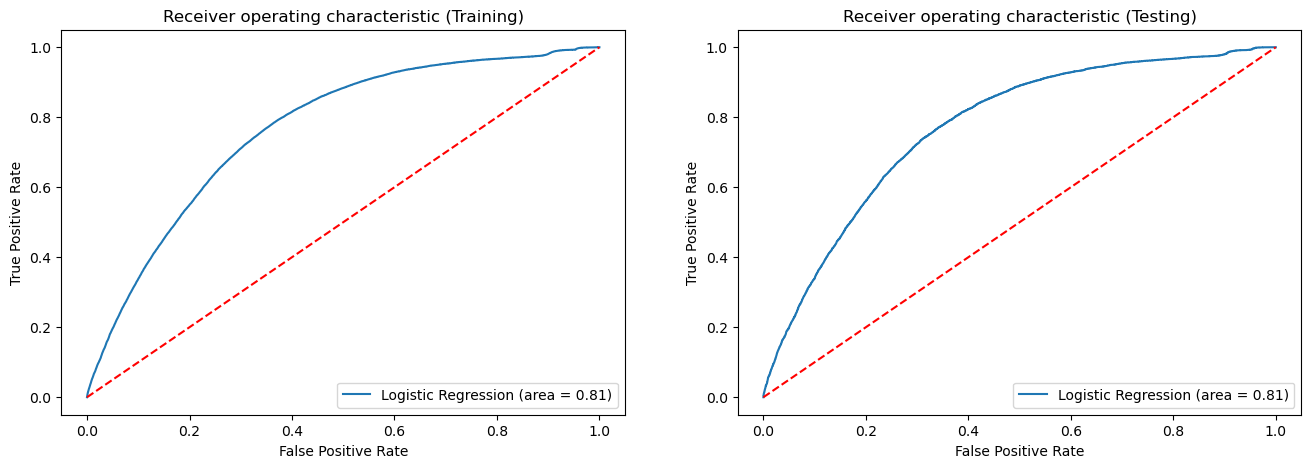

<IPython.core.display.Javascript object>

In [41]:
# ROC curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
nb_roc_auc_train = roc_auc_score(y_train, nb_classifier.predict_proba(X_train_scaled)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, nb_classifier.predict_proba(X_train_scaled)[:,1])
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Training)")
plt.legend(loc="lower right")
#plt.show()
plt.subplot(1, 2, 2)
nb_roc_auc_test = roc_auc_score(y_test, nb_classifier.predict_proba(X_test_scaled)[:,1])
fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test, nb_classifier.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr_tst, tpr_tst, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Testing)")
plt.legend(loc="lower right")
plt.show()

In [42]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low (using the tpr and fpr from the training dataset)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print('Optimal classification threshold based on ROC Curve: {}'.format(optimal_threshold_auc_roc))

Optimal classification threshold based on ROC Curve: 0.0871229260338956


<IPython.core.display.Javascript object>

In [43]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
nb_thres_train_perf = model_performance_classification_sklearn(nb_classifier, X_train_scaled, y_train, optimal_threshold_auc_roc)
display(nb_thres_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
nb_thres_test_perf = model_performance_classification_sklearn(nb_classifier, X_test_scaled, y_test, optimal_threshold_auc_roc)
display(nb_thres_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.658387,0.783959,0.279841,0.412453


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.659157,0.791708,0.281538,0.415368


<IPython.core.display.Javascript object>

### Decision Tree Classifier

In [44]:
tree = DecisionTreeClassifier(random_state = 42)

<IPython.core.display.Javascript object>

In [45]:
tree.fit(X_train_scaled,y_train)

DecisionTreeClassifier(random_state=42)

<IPython.core.display.Javascript object>

In [46]:
print(f'Train accuracy: {tree.score(X_train_scaled, y_train)}')
print(f'Test accuracy: {tree.score(X_test_scaled, y_test)}')

Train accuracy: 0.9945908845783015
Test accuracy: 0.7741366161891273


<IPython.core.display.Javascript object>

The gap between the training and testing accuracies show that there is overfitting

In [47]:
# evaluation metrics for classification
print(classification_report(y_test, tree.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     38876
         1.0       0.29      0.32      0.30      7019

    accuracy                           0.77     45895
   macro avg       0.58      0.59      0.58     45895
weighted avg       0.78      0.77      0.78     45895



<IPython.core.display.Javascript object>

In [48]:
tree.get_depth()

42

<IPython.core.display.Javascript object>

#### Hyperparameter Tuning for Decision Tree

In [49]:
# Grid of parameters to choose from
parameters = {
    # The maximum depth of the tree.
    "max_depth": np.arange(5, 42),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using column transformer and pipeline help in avoiding data leakage.
tree_random = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), parameters, scoring=acc_scorer, cv=10, n_jobs= -1,)

tree_random.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41])},
                   scoring=make_scorer(f1_score))

<IPython.core.display.Javascript object>

In [50]:
tree_random.best_params_

{'max_depth': 25}

<IPython.core.display.Javascript object>

In [51]:
# evaluation metrics for classification
print(classification_report(y_train, tree_random.best_estimator_.predict(X_train_scaled)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    155501
         1.0       0.98      0.90      0.94     28078

    accuracy                           0.98    183579
   macro avg       0.98      0.95      0.96    183579
weighted avg       0.98      0.98      0.98    183579



<IPython.core.display.Javascript object>

In [52]:
# evaluation metrics for classification
print(classification_report(y_test, tree_random.best_estimator_.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     38876
         1.0       0.30      0.31      0.30      7019

    accuracy                           0.78     45895
   macro avg       0.59      0.59      0.59     45895
weighted avg       0.79      0.78      0.78     45895



<IPython.core.display.Javascript object>

In [53]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
tree_train_perf = model_performance_classification_sklearn(tree_random.best_estimator_, X_train_scaled, y_train)
display(tree_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
tree_test_perf = model_performance_classification_sklearn(tree_random.best_estimator_, X_test_scaled, y_test)
display(tree_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.98136,0.895149,0.981337,0.936264


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.781806,0.309161,0.295842,0.302355


<IPython.core.display.Javascript object>

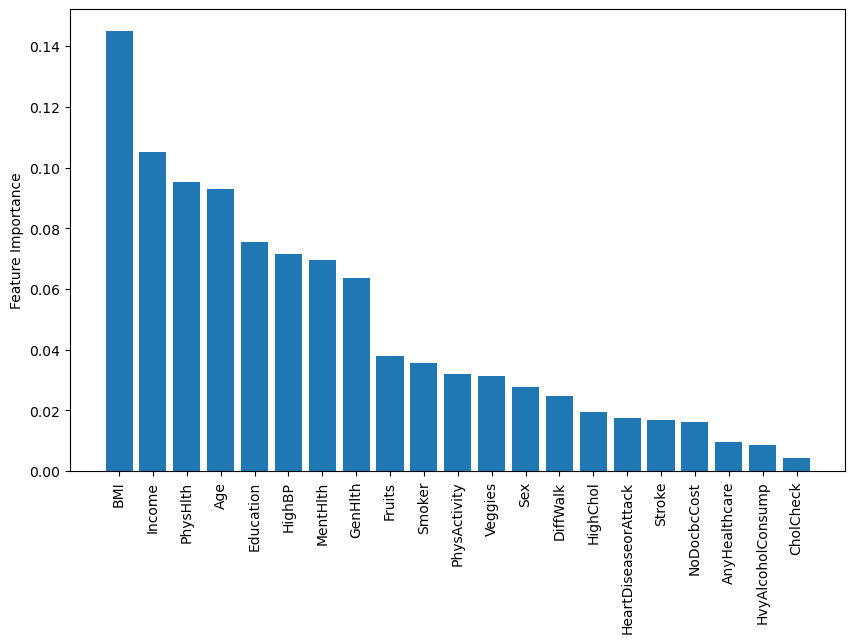

<IPython.core.display.Javascript object>

In [54]:
# Decision Tree Feature Importance

# compute feature importance
importance = tree_random.best_estimator_.feature_importances_

# output column labels 
feat_labels = X_train_scaled.columns

# sort the feature importance in descending order and get their index values and select the top 10
indices = np.argsort(importance)[::-1]

# plot only the top 10 features
top_n = len(X_train.columns)

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(top_n), importance[indices][:top_n], align='center')
plt.xticks(range(top_n), feat_labels[indices][:top_n], rotation=90)
plt.show()

## Ensembles

### Random Forest

In [55]:
forest = RandomForestClassifier(random_state=42)

<IPython.core.display.Javascript object>

In [56]:
forest.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=42)

<IPython.core.display.Javascript object>

In [57]:
print(f'Train accuracy: {forest.score(X_train_scaled, y_train)}')
print(f'Test accuracy: {forest.score(X_test_scaled, y_test)}')

Train accuracy: 0.9945527538552884
Test accuracy: 0.8432073210589389


<IPython.core.display.Javascript object>

In [58]:
# evaluation metrics for classification
print(classification_report(y_test, forest.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     38876
         1.0       0.47      0.17      0.25      7019

    accuracy                           0.84     45895
   macro avg       0.67      0.57      0.58     45895
weighted avg       0.80      0.84      0.81     45895



<IPython.core.display.Javascript object>

#### Hyperparameter Tuning for Random Forest

In [59]:
parameters = {
    "n_estimators": [20,50,100],
    "max_features": np.arange(0.6, 1, 0.1),
    "max_samples": np.arange(0.6, 1, 0.1),
    "max_depth":np.arange(20, 35, 1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using RandomizedSearchCV to find the optimal hyperparameters
forest_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), parameters, scoring=acc_scorer, cv=10, n_jobs= -1).fit(X_train_scaled, y_train);

params = forest_random.best_params_
params

{'n_estimators': 20,
 'max_samples': 0.8999999999999999,
 'max_features': 0.7,
 'max_depth': 23}

<IPython.core.display.Javascript object>

In [60]:
# evaluation metrics for classification
print(classification_report(y_test, forest_random.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     38876
         1.0       0.46      0.20      0.28      7019

    accuracy                           0.84     45895
   macro avg       0.67      0.58      0.60     45895
weighted avg       0.81      0.84      0.82     45895



<IPython.core.display.Javascript object>

In [61]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
forest_train_perf = model_performance_classification_sklearn(forest_random, X_train_scaled, y_train)
display(forest_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
forest_test_perf = model_performance_classification_sklearn(forest_random, X_test_scaled, y_test)
display(forest_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.974828,0.840053,0.994519,0.910783


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.841769,0.204018,0.460895,0.282836


<IPython.core.display.Javascript object>

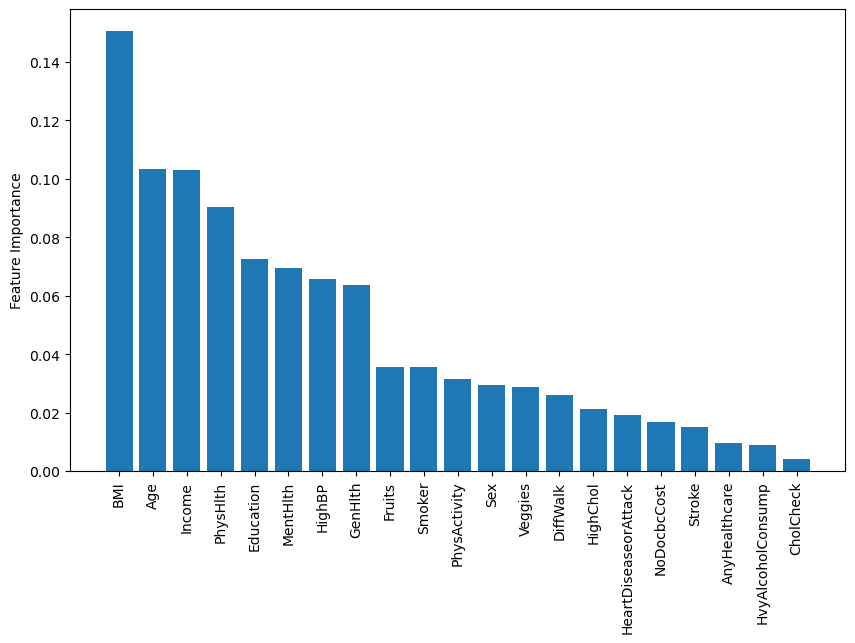

<IPython.core.display.Javascript object>

In [62]:
# LightGBM Feature Importance

# compute feature importance
importance = forest_random.best_estimator_.feature_importances_

# output column labels 
feat_labels = X_train_scaled.columns

# sort the feature importance in descending order and get their index values and select the top 10
indices = np.argsort(importance)[::-1]

# plot only the top 10 features
top_n = len(X_train.columns)

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(top_n), importance[indices][:top_n], align='center')
plt.xticks(range(top_n), feat_labels[indices][:top_n], rotation=90)
plt.show()

### LightGBM

In [63]:
lgbm = LGBMClassifier(random_state=42).fit(X_train_scaled, y_train)

<IPython.core.display.Javascript object>

In [64]:
# evaluation metrics for classification
print(classification_report(y_test, lgbm.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     38876
         1.0       0.61      0.17      0.26      7019

    accuracy                           0.86     45895
   macro avg       0.74      0.57      0.59     45895
weighted avg       0.83      0.86      0.82     45895



<IPython.core.display.Javascript object>

#### Hyperparameter Tuning for LIghtGBM

In [65]:
# hyperparameter tuning
parameters = {
    "max_depth": np.arange(1,3),
    "n_estimators": [20, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# decision tree pipeline
lgbm_random = RandomizedSearchCV(LGBMClassifier(random_state=42), parameters, scoring=acc_scorer, cv=10, n_jobs= -1).fit(X_train_scaled, y_train)


<IPython.core.display.Javascript object>

In [66]:
params = lgbm_random.best_params_
params

{'n_estimators': 20, 'max_depth': 2, 'learning_rate': 0.75}

<IPython.core.display.Javascript object>

In [67]:
# evaluation metrics for classification
print(classification_report(y_test, lgbm_random.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     38876
         1.0       0.58      0.17      0.26      7019

    accuracy                           0.85     45895
   macro avg       0.73      0.57      0.59     45895
weighted avg       0.82      0.85      0.82     45895



<IPython.core.display.Javascript object>

In [68]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
lgbm_train_perf = model_performance_classification_sklearn(lgbm_random, X_train_scaled, y_train)
display(lgbm_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
lgbm_test_perf = model_performance_classification_sklearn(lgbm_random, X_test_scaled, y_test)
display(lgbm_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.852805,0.160873,0.566182,0.250555


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.854516,0.167688,0.58499,0.260658


<IPython.core.display.Javascript object>

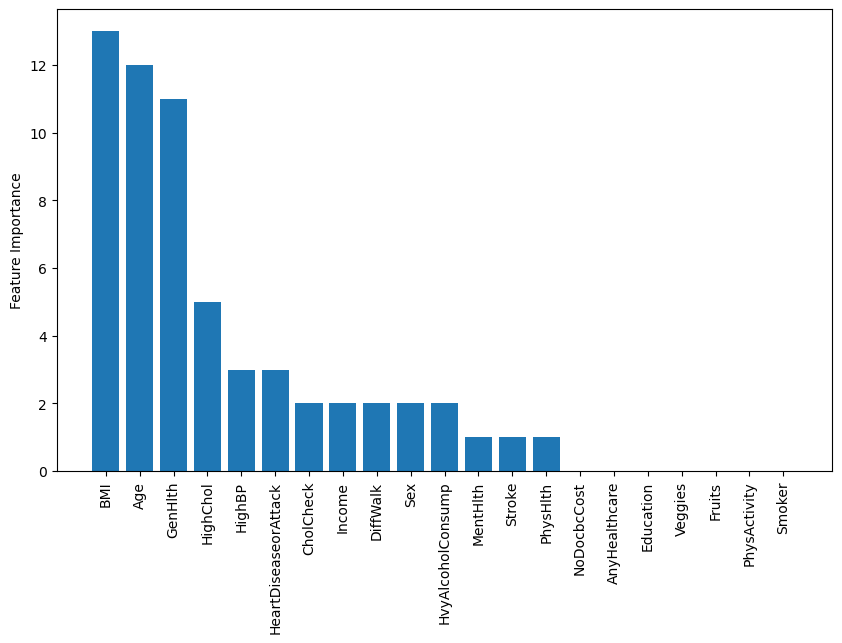

<IPython.core.display.Javascript object>

In [69]:
# LightGBM Feature Importance

# compute feature importance
importance = lgbm_random.best_estimator_.feature_importances_

# output column labels 
feat_labels = X_train_scaled.columns

# sort the feature importance in descending order and get their index values and select the top 10
indices = np.argsort(importance)[::-1]

# plot only the top 10 features
top_n = len(X_train.columns)

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(top_n), importance[indices][:top_n], align='center')
plt.xticks(range(top_n), feat_labels[indices][:top_n], rotation=90)
plt.show()

### ADA-Boost

In [70]:
# train AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42).fit(X_train_scaled, y_train)

<IPython.core.display.Javascript object>

In [71]:
# evaluation metrics for classification
print(classification_report(y_test, ada.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     38876
         1.0       0.57      0.19      0.28      7019

    accuracy                           0.85     45895
   macro avg       0.72      0.58      0.60     45895
weighted avg       0.82      0.85      0.82     45895



<IPython.core.display.Javascript object>

#### Hyperparameter Tuning for ADA-Boost

In [72]:
# hyperparameter tuning
parameters = {
    "n_estimators": [20, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using RandomizedSearchCV to find the optimal hyperparameters
ada_random=(
                    RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=42),
                                    param_distributions=parameters,
                                    scoring=acc_scorer,
                                    cv=10,
                                    n_jobs=-1,
                    )
                    .fit(X_train_scaled,y_train)
)


params = ada_random.best_params_
params

{'n_estimators': 200, 'learning_rate': 0.5}

<IPython.core.display.Javascript object>

In [73]:
# evaluation metrics for classification
print(classification_report(y_test, ada_random.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     38876
         1.0       0.57      0.19      0.28      7019

    accuracy                           0.85     45895
   macro avg       0.72      0.58      0.60     45895
weighted avg       0.82      0.85      0.82     45895



<IPython.core.display.Javascript object>

In [74]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
ada_train_perf = model_performance_classification_sklearn(ada_random, X_train_scaled, y_train)
display(ada_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
ada_test_perf = model_performance_classification_sklearn(ada_random, X_test_scaled, y_test)
display(ada_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.85238,0.175155,0.555204,0.266298


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.854363,0.186494,0.573368,0.281445


<IPython.core.display.Javascript object>

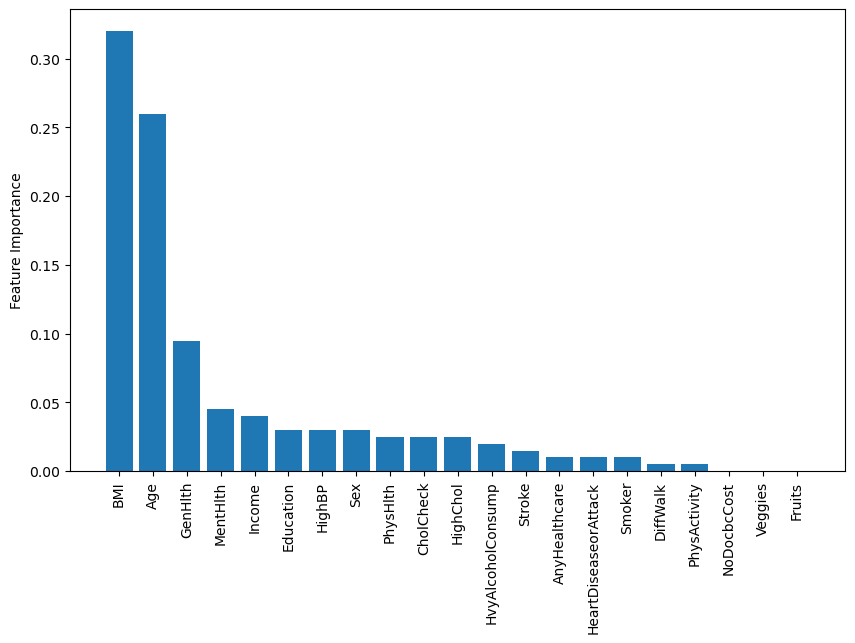

<IPython.core.display.Javascript object>

In [75]:
# AdaBoost Feature Importance

# compute feature importance
importance = ada_random.best_estimator_.feature_importances_

# output column labels 
feat_labels = X_train_scaled.columns

# sort the feature importance in descending order and get their index values and select the top 10
indices = np.argsort(importance)[::-1]

# plot only the top 10 features
top_n = len(X_train.columns)

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(top_n), importance[indices][:top_n], align='center')
plt.xticks(range(top_n), feat_labels[indices][:top_n], rotation=90)
plt.show()

### XG Boost

In [76]:
xgb = XGBClassifier(random_state=42).fit(X_train_scaled.infer_objects(), y_train)

<IPython.core.display.Javascript object>

In [77]:
print(f'Train accuracy: {xgb.score(X_train_scaled, y_train)}')
print(f'Test accuracy: {xgb.score(X_test_scaled, y_test)}')

Train accuracy: 0.863508353351963
Test accuracy: 0.85336093256346


<IPython.core.display.Javascript object>

In [78]:
# evaluation metrics for classification
print(classification_report(y_test, xgb.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     38876
         1.0       0.57      0.18      0.27      7019

    accuracy                           0.85     45895
   macro avg       0.72      0.58      0.59     45895
weighted avg       0.82      0.85      0.82     45895



<IPython.core.display.Javascript object>

#### Hyperparameter Tuning for XG Boost

In [79]:
# hyperparameter tuning
parameters = {
    "max_depth": [1, 2, 3, 4, 5, 6],
    "n_estimators": [10,30,50,100],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using RandomizedSearchCV to find the optimal hyperparameters
xgb_random=(
                    RandomizedSearchCV(estimator=XGBClassifier(random_state=42),
                                    param_distributions=parameters,
                                    scoring=acc_scorer,
                                    cv=10,
                                    n_jobs=-1,
                    )
                    .fit(X_train_scaled.infer_objects(),y_train)
)

<IPython.core.display.Javascript object>

In [80]:
# evaluation metrics for classification
print(classification_report(y_test, xgb_random.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.81     38876
         1.0       0.33      0.76      0.46      7019

    accuracy                           0.72     45895
   macro avg       0.64      0.74      0.64     45895
weighted avg       0.85      0.72      0.76     45895



<IPython.core.display.Javascript object>

In [81]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
xgb_train_perf = model_performance_classification_sklearn(xgb_random, X_train_scaled, y_train)
display(xgb_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
xgb_test_perf = model_performance_classification_sklearn(xgb_random, X_test_scaled, y_test)
display(xgb_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.725301,0.757639,0.327796,0.457607


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.72339,0.762787,0.326782,0.457548


<IPython.core.display.Javascript object>

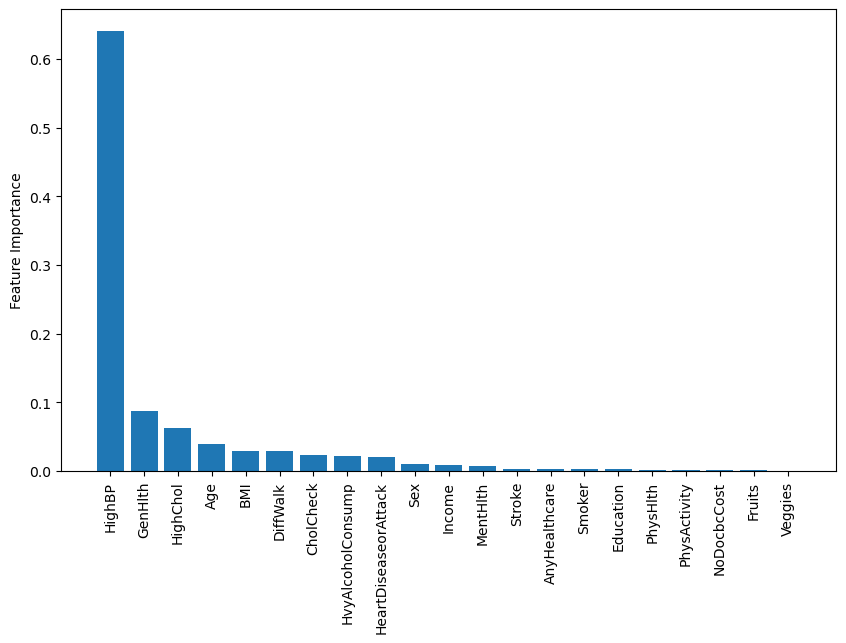

<IPython.core.display.Javascript object>

In [82]:
# XGBoost Feature Importance

# compute feature importance
importance = xgb_random.best_estimator_.feature_importances_

# output column labels 
feat_labels = X_train_scaled.columns

# sort the feature importance in descending order and get their index values and select the top 10
indices = np.argsort(importance)[::-1]

# plot only the top 10 features
top_n = len(X_train.columns)

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(top_n), importance[indices][:top_n], align='center')
plt.xticks(range(top_n), feat_labels[indices][:top_n], rotation=90)
plt.show()

### Meta-Learner method

In [83]:
estimators = [
    #('LogisticRegression', logit),
    #('NaiveBayes', nb_classifier),
    #
    ('Adaboost', ada_random.best_estimator_), 
    ('LightGBM',lgbm_random.best_estimator_),
    ('XGBoost',xgb_random.best_estimator_ )
]

final_estimator = xgb_random.best_estimator_

stacking_classifier = StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train_scaled.infer_objects(),y_train)

StackingClassifier(estimators=[('Adaboost',
                                AdaBoostClassifier(learning_rate=0.5,
                                                   n_estimators=200,
                                                   random_state=42)),
                               ('LightGBM',
                                LGBMClassifier(learning_rate=0.75, max_depth=2,
                                               n_estimators=20,
                                               random_state=42)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, device=None...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=4, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...))

<IPython.core.display.Javascript object>

In [84]:
# evaluation metrics for classification
print(classification_report(y_test, stacking_classifier.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     38876
         1.0       0.33      0.77      0.46      7019

    accuracy                           0.72     45895
   macro avg       0.63      0.74      0.64     45895
weighted avg       0.85      0.72      0.76     45895



<IPython.core.display.Javascript object>

In [85]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
meta_train_perf = model_performance_classification_sklearn(stacking_classifier, X_train_scaled, y_train)
display(meta_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
meta_test_perf = model_performance_classification_sklearn(stacking_classifier, X_test_scaled, y_test)
display(meta_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.723405,0.759741,0.326362,0.456588


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.721865,0.765921,0.325858,0.457201


<IPython.core.display.Javascript object>

In [86]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
meta_train_perf = model_performance_classification_sklearn(stacking_classifier, X_train_scaled, y_train)
display(meta_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
meta_test_perf = model_performance_classification_sklearn(stacking_classifier, X_test_scaled, y_test)
display(meta_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.723405,0.759741,0.326362,0.456588


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.721865,0.765921,0.325858,0.457201


<IPython.core.display.Javascript object>

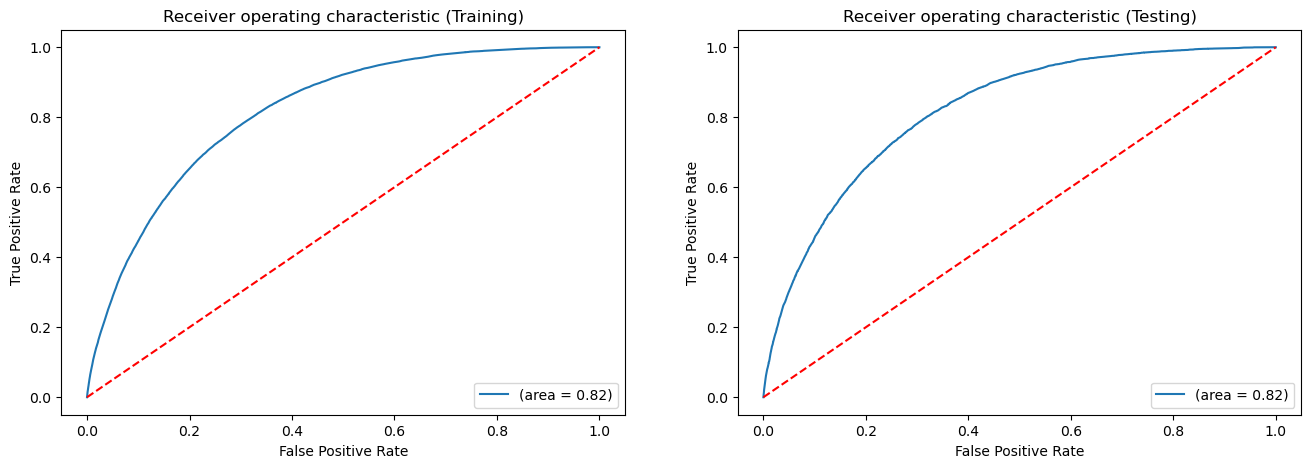

<IPython.core.display.Javascript object>

In [87]:
# ROC curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
meta_roc_auc_train = roc_auc_score(y_train, stacking_classifier.predict_proba(X_train_scaled)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, stacking_classifier.predict_proba(X_train_scaled)[:,1])
plt.plot(fpr, tpr, label="(area = %0.2f)" % meta_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Training)")
plt.legend(loc="lower right")
#plt.show()
plt.subplot(1, 2, 2)
meta_roc_auc_test = roc_auc_score(y_test, stacking_classifier.predict_proba(X_test_scaled)[:,1])
fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test, stacking_classifier.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr_tst, tpr_tst, label="(area = %0.2f)" % meta_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (Testing)")
plt.legend(loc="lower right")
plt.show()

In [88]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low (using the tpr and fpr from the training dataset)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print('Optimal classification threshold based on ROC Curve: {}'.format(optimal_threshold_auc_roc))

Optimal classification threshold based on ROC Curve: 0.4869365692138672


<IPython.core.display.Javascript object>

In [89]:
# model performance on the training dataset
print('Evaluation metrics on the training dataset')
meta_thres_train_perf = model_performance_classification_sklearn(stacking_classifier, X_train_scaled, y_train, optimal_threshold_auc_roc)
display(meta_thres_train_perf)

# model performance on the testing dataset
print('Evaluation metrics on the testing dataset')
meta_thres_test_perf = model_performance_classification_sklearn(stacking_classifier, X_test_scaled, y_test, optimal_threshold_auc_roc)
display(meta_thres_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.708817,0.782819,0.317002,0.451265


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.70755,0.789001,0.316837,0.452119


<IPython.core.display.Javascript object>

## Model Comparisions

In [90]:
# training performance comparison
models_train_comp_df = pd.concat(
    [
        logit_train_perf.T,
        logit_thres_train_perf.T,
        nb_train_perf.T,
        nb_thres_train_perf.T,
        tree_train_perf.T,
        forest_train_perf.T,
        lgbm_train_perf.T,
        ada_train_perf.T,
        xgb_train_perf.T,
        meta_train_perf.T,
        meta_thres_train_perf.T
    ],
    axis=1,
)

models_train_comp_df.columns = [
    'Logistic Regression','Logistic Regression (changed threshold)','Naive Bayes','Naive Bayes (changed threshold)',
    'Decision Tree','Random Forest',
    'Light GBM', 'ADA Boost', 'XG Boost', 'Meta-Learner', 'Meta-Learner (changed threshold)'
]


print("Training performance comparison:")
display(models_train_comp_df.T)

Training performance comparison:


,Accuracy,Recall,Precision,F1
Logistic Regression,0.850397,0.148515,0.539736,0.232935
Logistic Regression (changed threshold),0.701344,0.779863,0.310406,0.444064
Naive Bayes,0.755500,0.569984,0.327850,0.416267
Naive Bayes (changed threshold),0.658387,0.783959,0.279841,0.412453
Decision Tree,0.981360,0.895149,0.981337,0.936264
Random Forest,0.974828,0.840053,0.994519,0.910783
Light GBM,0.852805,0.160873,0.566182,0.250555
ADA Boost,0.852380,0.175155,0.555204,0.266298
XG Boost,0.725301,0.757639,0.327796,0.457607
Meta-Learner,0.723405,0.759741,0.326362,0.456588


<IPython.core.display.Javascript object>

In [91]:
# test performance comparison
models_test_comp_df = pd.concat(
    [
        logit_test_perf.T,
        logit_thres_test_perf.T,
        nb_test_perf.T,
        nb_thres_test_perf.T,
        tree_test_perf.T,
        forest_test_perf.T,
        lgbm_test_perf.T,
        ada_test_perf.T,
        xgb_test_perf.T,
        meta_test_perf.T,
        meta_thres_test_perf.T
    ],
    axis=1,
)

models_test_comp_df.columns = [
    'Logistic Regression','Logistic Regression (changed threshold)','Naive Bayes','Naive Bayes (changed threshold)',
    'Decision Tree','Random Forest',
    'Light GBM', 'ADA Boost', 'XG Boost', 'Meta-Learner', 'Meta-Learner (changed threshold)'
]


print("Testing performance comparison:")
display(models_test_comp_df.T)

Testing performance comparison:


,Accuracy,Recall,Precision,F1
Logistic Regression,0.850550,0.154153,0.539920,0.239832
Logistic Regression (changed threshold),0.698137,0.785155,0.308618,0.443078
Naive Bayes,0.756727,0.583416,0.331955,0.423146
Naive Bayes (changed threshold),0.659157,0.791708,0.281538,0.415368
Decision Tree,0.781806,0.309161,0.295842,0.302355
Random Forest,0.841769,0.204018,0.460895,0.282836
Light GBM,0.854516,0.167688,0.584990,0.260658
ADA Boost,0.854363,0.186494,0.573368,0.281445
XG Boost,0.723390,0.762787,0.326782,0.457548
Meta-Learner,0.721865,0.765921,0.325858,0.457201


<IPython.core.display.Javascript object>

### Visualising the Results

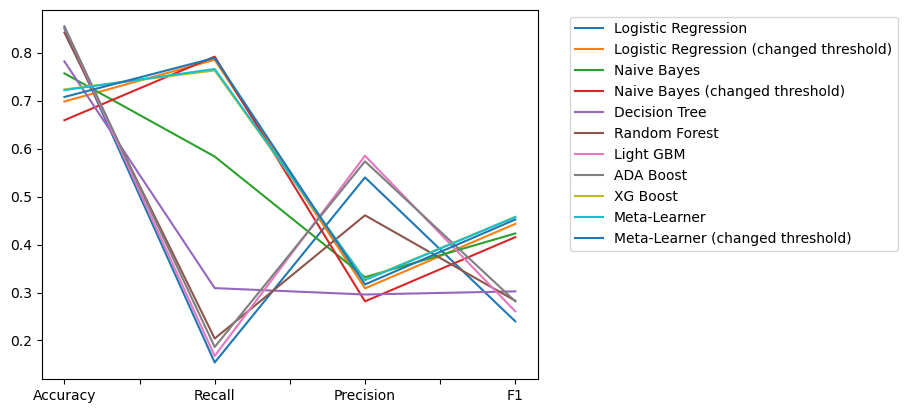

<IPython.core.display.Javascript object>

In [92]:
#models_test_comp_df.plot()

# Plotting the DataFrame
ax = models_test_comp_df.plot()
# Placing the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()

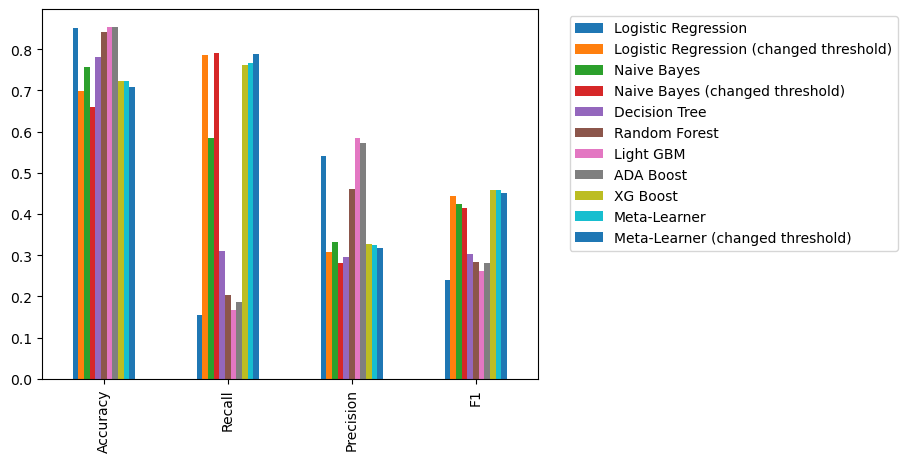

<IPython.core.display.Javascript object>

In [93]:
#models_test_comp_df.plot()

# Plotting the DataFrame
ax = models_test_comp_df.plot.bar()
# Placing the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()

In [94]:
import shap

<IPython.core.display.Javascript object>

[17:37:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


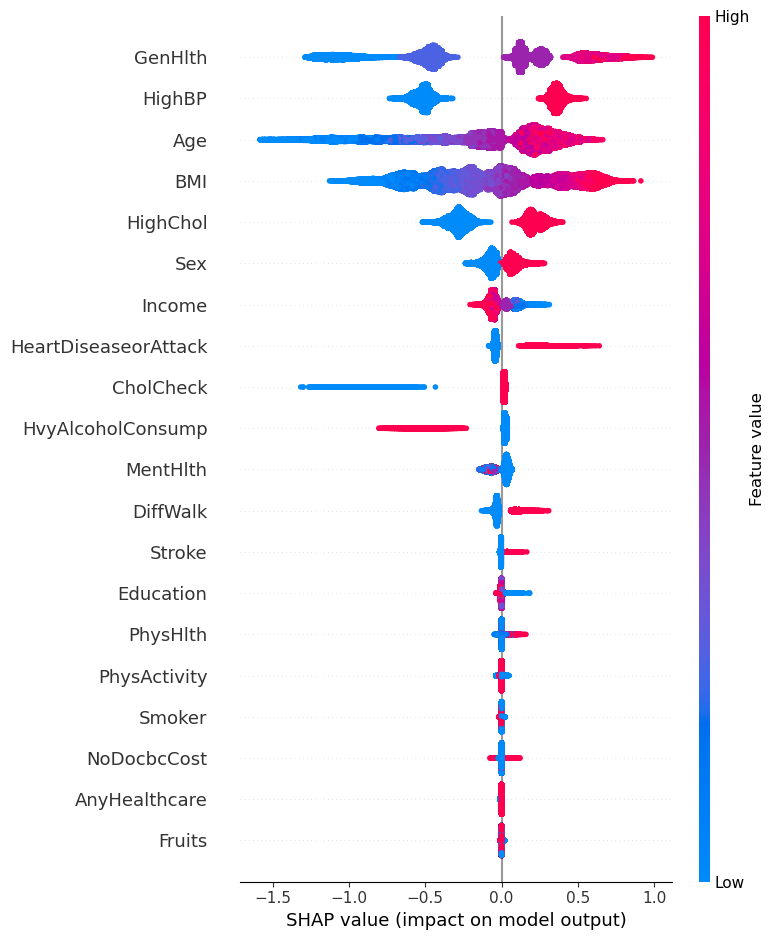

<IPython.core.display.Javascript object>

In [95]:
# Initialize a SHAP explainer with the final_estimator (XGBoost in this case)
explainer = shap.TreeExplainer(final_estimator)
 
# Ensure the column names and types match the training data used by the model
X_train_shap = pd.DataFrame(X_train_scaled, columns=X_train_scaled.columns)
 
# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_train_shap)
 
# Summary plot for an overview of feature importance
shap.summary_plot(shap_values, X_train_shap)
 
# Individual SHAP value plot for a specific instance (replace index with the desired row)
index = 0  # Change this to the index of the instance you want to visualize
shap.force_plot(explainer.expected_value, shap_values[index, :], X_train_shap.iloc[index, :])